This notebook will regroup analysis performed on full body tracking data related to the TNT screen

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
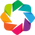

/home/durrieu/miniforge3/envs/tracking_analysis/lib/python3.12/site-packages/starlette/formparsers.py:12: FutureWarning: Please use `import python_multipart` instead.
  import multipart


Loading BallPushing utils version 20 Jan 2025


In [1]:
from pathlib import Path
import json
import pyarrow
import math
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from scipy.stats import gaussian_kde
from scipy.ndimage import label
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

from shiny import App, Inputs, Outputs, Session, reactive, render, req, ui

from utils_behavior import Sleap_utils, HoloviewsTemplates, Utils, Processing, Ballpushing_utils, Seaborn_Templates

import importlib

> Note that my dataclasses are too heavy (~ 2 Gb each) to be easily computed directly in the notebook. That is why a script called "DataSetBuilder.py" was used to generate a dataset based on TNT data

# Data prep

In [ ]:
importlib.reload(Utils)

In [31]:
datapath = Utils.get_data_server()

datapath

PosixPath('/mnt/upramdya_data')

In [32]:
# Import the Split registry

SplitRegistry = pd.read_csv(datapath / 'MD/MultiMazeRecorder/Datasets/SplitRegistry.csv')

SplitRegistry

,Bloomington\nnumber,Codename,Stock\nnumber,Genotype,Split
0,NaN,PR,M-7,PR,m
1,50742,TNTxZ1676,Z-1676,w[*]; P{w[+m*]=Mef2-GAL4.247}3,n
2,39552,TNTxZ1661,Z-1661,w[1118]; P{y[+t7.7] w[+mC]=GMR70G12-GAL4}attP2,n
3,73068 + 75042,TNTxZ1711,Z-1711,w[1118]; P{y[+t7.7] w[+mC]=VT029362-p65.AD}attP40,y
4,75029 + 71982,TNTxZ1712,Z-1712,w[1118]; P{y[+t7.7] w[+mC]=VT013618-p65.AD}attP40,y
...,...,...,...,...,...
214,86669,TNTxZ1868,Z-1868,w[1118]; P{y[+t7.7] w[+mC]=R22B12-p65.AD}attP4...,y
215,86670,TNTxZ1869,Z-1869,w[1118]; P{y[+t7.7] w[+mC]=R43D01-p65.AD}attP4...,y
216,86671,TNTxZ1870,Z-1870,w[1118]; P{y[+t7.7] w[+mC]=R22B12-p65.AD}attP4...,y
217,86674,TNTxZ1871,Z-1871,w[1118]; P{y[+t7.7] w[+mC]=R82F03-p65.AD}attP4...,y


In [33]:
# Drop the Genotype column and rename the column Codename to Genotype

SplitRegistry = SplitRegistry.drop(columns=['Genotype'])

SplitRegistry = SplitRegistry.rename(columns={'Codename':'Genotype'})

SplitRegistry

,Bloomington\nnumber,Genotype,Stock\nnumber,Split
0,NaN,PR,M-7,m
1,50742,TNTxZ1676,Z-1676,n
2,39552,TNTxZ1661,Z-1661,n
3,73068 + 75042,TNTxZ1711,Z-1711,y
4,75029 + 71982,TNTxZ1712,Z-1712,y
...,...,...,...,...
214,86669,TNTxZ1868,Z-1868,y
215,86670,TNTxZ1869,Z-1869,y
216,86671,TNTxZ1870,Z-1870,y
217,86674,TNTxZ1871,Z-1871,y


# Summaries

In [34]:
# Short contacts

Summary_data = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/250109_FinalEventCutoffData_norm/summary/250106_Pooled_summary.feather")

In [35]:
# Check number of unique values in the fly column

Summary_data['fly'].nunique()

3269

In [36]:
# Add the Split column from the SplitRegistry to the Disp_Data, merging based on the Genotype column

Summary_data = pd.merge(Summary_data, SplitRegistry, on='Genotype', how='left')

Summary_data.head()

,index,nb_events,max_event,max_event_time,max_distance,final_event,final_event_time,nb_significant_events,significant_ratio,first_significant_event,...,Date,Genotype,Period,FeedingState,Orientation,Light,Crossing,Bloomington\nnumber,Stock\nnumber,Split
0,fly_0_ball_0,3.333269,11.0,759.310345,204.707942,11.0,759.310345,7.0,2.100040,1.0,...,231121,TNTxG78,PM14,starved_noWater,std,on,1,68255,G-78,y
1,fly_0_ball_0,2.777725,9.0,1267.517241,181.056997,9.0,1267.517241,2.0,0.720014,7.0,...,231121,TNTxG78,PM14,starved_noWater,std,on,1,68255,G-78,y
2,fly_0_ball_0,2.499952,8.0,819.655172,181.513577,8.0,819.655172,5.0,2.000038,1.0,...,231121,TNTxG78,PM14,starved_noWater,std,on,1,68255,G-78,y
3,fly_0_ball_0,1.111090,3.0,216.482759,233.462500,3.0,216.482759,4.0,3.600069,0.0,...,231121,TNTxG78,PM14,starved_noWater,std,on,1,68255,G-78,y
4,fly_0_ball_0,0.555545,1.0,125.241379,228.420176,1.0,125.241379,2.0,3.600069,0.0,...,231121,TNTxG78,PM14,starved_noWater,std,on,1,68255,G-78,y


In [40]:
# Replace the missing Split values with the correct values

# If the Nickname is "GMR70G12-Gal4" or "MB247-Gal4" or "Ple-Gal4.F a.k.a TH-Gal4" or "DDC-gal4", set the Split to "n"

Summary_data.loc[Summary_data['Nickname'].isin(['GMR70G12-Gal4', 'MB247-Gal4', 'Ple-Gal4.F a.k.a TH-Gal4', 'DDC-gal4']), 'Split'] = 'n'

# If the Nickname is "TNTxPR" or "TNTxCS", set the Split to "m"

Summary_data.loc[Summary_data['Nickname'].isin(['TNTxPR', 'TNTxCS']), 'Split'] = 'm'

# If the Nickname is "SS32219-Gal4 (LAL-2)" or "SS32230-Gal4 (LAL-1)"  , set the Split to "y"

Summary_data.loc[Summary_data['Nickname'].isin(['SS32219-Gal4 (LAL-2)', 'SS32230-Gal4 (LAL-1)']), 'Split'] = 'y'

In [41]:
Summary_data=Summary_data[~Summary_data["Genotype"].isin(["M6", "M7", "PR", "CS"])]

In [42]:
# Check for NA values in the Split column

Summary_data['Split'].isna().sum()

np.int64(0)

In [43]:
# Check which Nicknames have NA values in the Split column

Summary_data[Summary_data['Split'].isna()]['Nickname'].unique()

array([], dtype=object)

In [44]:
Summary_data.columns

Index(['index', 'nb_events', 'max_event', 'max_event_time', 'max_distance',
       'final_event', 'final_event_time', 'nb_significant_events',
       'significant_ratio', 'first_significant_event',
       'first_significant_event_time', 'aha_moment', 'aha_moment_time',
       'insight_effect', 'cumulated_breaks_duration', 'pushed', 'pulled',
       'pulling_ratio', 'success_direction', 'interaction_proportion',
       'distance_moved', 'exit_time', 'fly', 'flypath', 'experiment',
       'Nickname', 'Brain region', 'Date', 'Genotype', 'Period',
       'FeedingState', 'Orientation', 'Light', 'Crossing',
       'Bloomington\nnumber', 'Stock\nnumber', 'Split'],
      dtype='object')

In [53]:
controls = [#'TNTxCS', 
            #'TNTxPR', 
            'Empty-Gal4', 'Empty-Split'] # Replace with your list of genotypes

In [46]:
# List of metrics
metrics = ['nb_events', 'max_event', 'max_event_time', 'max_distance',
           'final_event', 'final_event_time', 'nb_significant_events',
           'significant_ratio', 'first_significant_event',
           'first_significant_event_time', 'aha_moment', 'aha_moment_time',
           'insight_effect', 'cumulated_breaks_duration', 'pushed', 'pulled',
           'pulling_ratio', 'interaction_proportion', 'distance_moved']

In [47]:
# Check which metrics have NA values

Summary_data[metrics].isna().sum()

nb_events                        0
max_event                       10
max_event_time                  10
max_distance                     0
final_event                     40
final_event_time                40
nb_significant_events            0
significant_ratio                0
first_significant_event          7
first_significant_event_time     7
aha_moment                      21
aha_moment_time                 21
insight_effect                   0
cumulated_breaks_duration        0
pushed                           0
pulled                           0
pulling_ratio                    7
interaction_proportion           0
distance_moved                   0
dtype: int64

In [48]:
pca_metrics = ['nb_events', 'max_distance',
            'nb_significant_events',
           'significant_ratio', 'cumulated_breaks_duration', 'pushed', 'pulled',
            'interaction_proportion', 'distance_moved']

In [ ]:
importlib.reload(HoloviewsTemplates)

importlib.reload(HoloviewsTemplates)

In [49]:
# Find out what is the maximum value of insight_effect

Summary_data['insight_effect'].max()

np.float64(1.0)

In [50]:
# Check if there are any NA values in the insight_effect column or Inf

Summary_data['insight_effect'].isna().sum()

np.int64(0)

In [ ]:
plot = HoloviewsTemplates.jitter_boxplot(data=Summary_data, metric="pulling_ratio", kdims="Nickname",groupby="Brain region", render="grouped", control=controls, hline="bootstrap")

plot

In [54]:
for metric in metrics:
    plot = HoloviewsTemplates.jitter_boxplot(data=Summary_data, metric=metric, kdims="Nickname",groupby="Brain region", render="grouped", control=controls, hline="bootstrap")

    hv.save(plot, f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250203_Summary/{metric}_3.html")



In [ ]:
# Plot each of them for 

summary_plots = []

for metric in metrics:
    plot = Seaborn_Templates.sns_plot(Summary_data, metric, "Nickname", "jitterboxplot", group_by="Brain region" )
    
    summary_plots.append(plot)

In [ ]:
summary_plots[0]

In [ ]:
from IPython.display import display


In [55]:
# List of metrics
metrics = metrics

# List of metadata columns
metadata_columns = ['exit_time', 'fly', 'flypath', 'experiment', 'Nickname', 
                    'Brain region', 'Date', 'Genotype', 'Period', 'FeedingState', 
                    'Orientation', 'Light', 'Crossing', 'Split']

# Replace infinity values with NaN
Summary_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
cleaned_data = Summary_data.dropna(subset=metrics)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cleaned_data[metrics])

n_components = 5

# Perform PCA
pca = PCA(n_components=n_components)
pca.fit(normalized_data)
pca_data = pca.transform(normalized_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the metadata columns with the PCA results
pca_results = pd.concat([cleaned_data[metadata_columns].reset_index(drop=True), pca_df], axis=1)

# Get explained variance and loadings
explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Create a DataFrame for the explained variance
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(n_components)],
    'Explained Variance': explained_variance
})

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(n_components)], index=metrics)

# Display the explained variance and loadings as tables
print("Explained Variance:")
display(explained_variance_df.style.set_caption("Explained Variance").set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'black'), ('font-size', '16px')]
}]))

print("\nLoadings:")
display(loadings_df.style.set_caption("Loadings").set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'black'), ('font-size', '16px')]
}]))

# Example plot for the first principal component
#plot = HoloviewsTemplates.jitter_boxplot(data=pca_results, metric="PC1", kdims="Nickname", groupby="Brain region", render="grouped", control=controls, hline="boxplot")
#hv.save(plot, 'pca_plot.html')
#plot

Explained Variance:


,Principal Component,Explained Variance
0,PC1,0.405721
1,PC2,0.197696
2,PC3,0.113415
3,PC4,0.058080
4,PC5,0.053464



Loadings:


,PC1,PC2,PC3,PC4,PC5
nb_events,0.320183,-0.192073,0.077578,0.072078,0.065178
max_event,0.319814,-0.191254,0.079832,0.064601,0.072213
max_event_time,0.290279,0.242609,-0.211063,-0.013920,0.060466
max_distance,-0.039833,0.011735,0.048079,-0.377502,0.851361
final_event,0.320183,-0.192073,0.077578,0.072078,0.065178
final_event_time,0.290853,0.241818,-0.213129,-0.004634,0.056012
nb_significant_events,0.275791,-0.273136,-0.140814,-0.132244,-0.081142
significant_ratio,-0.204257,-0.081197,-0.304173,-0.397861,-0.093635
first_significant_event,0.133769,0.144638,0.465575,0.066260,0.095640
first_significant_event_time,0.110645,0.423159,-0.045864,-0.244804,-0.034651


In [ ]:
# Plot PC2 the same way

plot = HoloviewsTemplates.jitter_boxplot(data=pca_results, metric="PC2", kdims="Nickname",groupby="Brain region", render="grouped", control=controls, hline="boxplot")

plot

In [ ]:
# Plot a scatter plot of PC1 vs PC2

plot = sns.jointplot(data=pca_results, x='PC1', y='PC2', hue='Brain region', kind='scatter')

plot

In [ ]:
#control_nicknames = ['TNTxCS', 'TNTxPR', 'Empty-Gal4', 'Empty-Split']

control_nicknames = ['Empty-Gal4', 'Empty-Split']

In [ ]:
pca_results

In [ ]:
# Define the control region and get unique nicknames
control_region = 'Control'
control_nicknames_dict = {
    'y': 'Empty-Split',
    'n': 'Empty-Gal4',
    'm': 'TNTxPR'
}
nicknames = pca_results['Nickname'].unique()
nicknames = [nickname for nickname in nicknames if nickname not in control_nicknames_dict.values()]


# Manually create a color dictionary for the brain regions
color_dict = {
    'MB': '#1f77b4',  # Blue
    'Vision': '#ff7f0e',  # Orange
    'LH': '#2ca02c',  # Green
    'Neuropeptide': '#d62728',  # Red
    'Olfaction': '#9467bd',  # Purple
    'MB extrinsic neurons': '#8c564b',  # Brown
    'CX': '#e377c2',  # Pink
    'Control': '#7f7f7f',  # Gray
    'None': '#bcbd22',  # Yellow-green
    'fchON': '#17becf',  # Cyan
    'JON': '#ffbb78',  # Light orange
}

In [ ]:

# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(nicknames)
n_cols = 15  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 10*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each Nickname and create a subplot
for i, nickname in enumerate(nicknames):
    # Subset the data for the Control Brain region and the current Nickname
    subset_data = pca_results[pca_results['Nickname'].isin([nickname] + list(control_nicknames))]
    
    # Plot the distribution
    sns.scatterplot(data=subset_data[subset_data['Nickname'] == nickname], x='PC1', y='PC2', hue='Brain region', palette=color_dict, ax=axes[i], marker='o', s=100)
    sns.scatterplot(data=subset_data[subset_data['Nickname'].isin(control_nicknames)], x='PC1', y='PC2', hue='Brain region', palette=color_dict, ax=axes[i], marker='X', s=100, legend=False)
    
    # Set the title for the subplot
    axes[i].set_title(f'{nickname} vs Controls')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250109_SummaryMetrics/PC1_vs_PC2_Scatter_Full.png")

# Show the plot
plt.show()

In [ ]:

# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(nicknames)
n_cols = 15  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 10*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Initialize random generator
rg = np.random.default_rng()

# Loop through each Nickname and create a subplot
for i, nickname in enumerate(nicknames):
    # Subset the data for the Control Brain region and the current Nickname
    subset_data = pca_results[pca_results['Nickname'].isin([nickname] + list(control_nicknames))]
    
    # Compute bootstrap confidence intervals
    nickname_data = subset_data[subset_data['Nickname'] == nickname]
    control_data = subset_data[subset_data['Nickname'].isin(control_nicknames)]
    
    ci_nickname_pc1 = Processing.draw_bs_ci(nickname_data['PC1'], rg=rg)
    ci_control_pc1 = Processing.draw_bs_ci(control_data['PC1'], rg=rg)
    
    ci_nickname_pc2 = Processing.draw_bs_ci(nickname_data['PC2'], rg=rg)
    ci_control_pc2 = Processing.draw_bs_ci(control_data['PC2'], rg=rg)
    
    # Check for non-overlapping confidence intervals
    pc1_lower = ci_nickname_pc1[1] < ci_control_pc1[0]
    pc1_higher = ci_nickname_pc1[0] > ci_control_pc1[1]
    pc2_lower = ci_nickname_pc2[1] < ci_control_pc2[0]
    pc2_higher = ci_nickname_pc2[0] > ci_control_pc2[1]
    
    # Plot the distribution
    sns.scatterplot(data=nickname_data, x='PC1', y='PC2', hue='Brain region', palette=color_dict, ax=axes[i], marker='o', s=100)
    sns.scatterplot(data=control_data, x='PC1', y='PC2', hue='Brain region', palette=color_dict, ax=axes[i], marker='X', s=100, legend=False)
    
    # Set the title for the subplot
    title = f'{nickname} vs Controls'
    if pc1_lower:
        title += ' (PC1 lower)'
    if pc1_higher:
        title += ' (PC1 higher)'
    if pc2_lower:
        title += ' (PC2 lower)'
    if pc2_higher:
        title += ' (PC2 higher)'
    axes[i].set_title(title)
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    
    # Change background color based on conditions
    if pc1_lower and pc2_higher:
        axes[i].set_facecolor('green')
    elif pc1_higher and pc2_lower:
        axes[i].set_facecolor('red')
    elif (pc1_lower and pc2_lower) or (pc1_higher and pc2_higher):
        axes[i].set_facecolor('yellow')
    elif pc1_lower or pc2_higher:
        axes[i].set_facecolor('lightgreen')
    elif pc1_higher or pc2_lower:
        axes[i].set_facecolor('lightcoral')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250109_SummaryMetrics/PC1_vs_PC2_Scatter_withstats_EmptyOnly.png")

# Show the plot
plt.show()

In [ ]:
control_nicknames

In [ ]:
# Compute the bootstrapped confidence interval for each control group
ci_controls = {}
for split, control_nickname in control_nicknames_dict.items():
    control_data = pca_results[pca_results['Nickname'] == control_nickname]
    ci_controls[split] = {
        'PC1': Processing.draw_bs_ci(control_data['PC1'], rg=rg),
        'PC2': Processing.draw_bs_ci(control_data['PC2'], rg=rg)
    }


In [ ]:
# Sort the data by Brain region

pca_results = pca_results.sort_values(by='Brain region')

In [ ]:

# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(nicknames)
n_cols = 15  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 10*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each Nickname and create a subplot
for i, nickname in enumerate(nicknames):
    print(f'Processing {nickname}...')
    
    # Subset the data for the current Nickname
    nickname_data = pca_results[pca_results['Nickname'] == nickname]
    
    print(nickname_data[['Nickname', 'Split']].drop_duplicates())
    
    # Get the appropriate control group based on the Split column
    split_value = nickname_data['Split'].iloc[0]
    associated_control = control_nicknames_dict[split_value]
    
    print(f'Associated control is : {associated_control}')
    
    # Subset the data for the relevant control group
    control_data = pca_results[pca_results['Nickname'] == associated_control]
    
    # Combine the nickname data with the relevant control data
    subset_data = pd.concat([nickname_data, control_data])
    
    # Debugging information
    #print(subset_data[['Nickname', 'Split']].drop_duplicates())
    print(f'Associated control is : {associated_control}')
    
    # Map the colors based on the brain region
    subset_data['color'] = subset_data['Brain region'].map(color_dict)
    
    # Subset the data for the relevant control group
    control_data = pca_results[pca_results['Nickname'] == associated_control]
    
    # Compute bootstrap confidence intervals
    ci_nickname_pc1 = Processing.draw_bs_ci(nickname_data['PC1'], rg=rg)
    ci_control_pc1 = ci_controls[split_value]['PC1']
    
    ci_nickname_pc2 = Processing.draw_bs_ci(nickname_data['PC2'], rg=rg)
    ci_control_pc2 = ci_controls[split_value]['PC2']
    
    # Check for non-overlapping confidence intervals
    pc1_lower = ci_nickname_pc1[1] < ci_control_pc1[0]
    pc1_higher = ci_nickname_pc1[0] > ci_control_pc1[1]
    pc2_lower = ci_nickname_pc2[1] < ci_control_pc2[0]
    pc2_higher = ci_nickname_pc2[0] > ci_control_pc2[1]
    
    # Plot the distribution
    sns.scatterplot(data=nickname_data, x='PC1', y='PC2', hue='Brain region', palette=color_dict, ax=axes[i], marker='o', s=100)
    sns.scatterplot(data=control_data, x='PC1', y='PC2', hue='Brain region', palette=color_dict, ax=axes[i], marker='X', s=100, legend=False)
    
    # Set the title for the subplot
    title = f'{nickname} vs Controls'
    if pc1_lower:
        title += ' (PC1 lower)'
    if pc1_higher:
        title += ' (PC1 higher)'
    if pc2_lower:
        title += ' (PC2 lower)'
    if pc2_higher:
        title += ' (PC2 higher)'
    axes[i].set_title(title)
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    
    # Change background color based on conditions
    if pc1_lower and pc2_higher:
        axes[i].set_facecolor('green')
    elif pc1_higher and pc2_lower:
        axes[i].set_facecolor('red')
    elif (pc1_lower and pc2_lower) or (pc1_higher and pc2_higher):
        axes[i].set_facecolor('yellow')
    elif pc1_lower or pc2_higher:
        axes[i].set_facecolor('lightgreen')
    elif pc1_higher or pc2_lower:
        axes[i].set_facecolor('lightcoral')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250109_SummaryMetrics/PC1_vs_PC2_Scatter_withstats_RefinedCtrl.png")

# Show the plot
plt.show()

# Analysis of ball derivative for contact indices

In [ ]:
# Short contacts

Disp_Data = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/241218_FinalEventCutoffData_norm/Skeleton_contacts/241209_Pooled_Skeleton_contacts.feather")

# Long contacts

# Disp_Data = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/250106_FinalEventCutoffData_norm/Skeleton_contacts/250106_Pooled_Skeleton_contacts.feather")


In [ ]:
Disp_Data.head()

In [ ]:
# Add the Split column from the SplitRegistry to the Disp_Data, merging based on the Genotype column

Disp_Data = pd.merge(Disp_Data, SplitRegistry, on='Genotype', how='left')

Disp_Data.head()

In [ ]:
# Replace the missing Split values with the correct values

# If the Nickname is "GMR70G12-Gal4" or "MB247-Gal4" or "Ple-Gal4.F a.k.a TH-Gal4" or "DDC-gal4", set the Split to "n"

Disp_Data.loc[Disp_Data['Nickname'].isin(['GMR70G12-Gal4', 'MB247-Gal4', 'Ple-Gal4.F a.k.a TH-Gal4', 'DDC-gal4']), 'Split'] = 'n'

# If the Nickname is "TNTxPR" or "TNTxCS", set the Split to "m"

Disp_Data.loc[Disp_Data['Nickname'].isin(['TNTxPR', 'TNTxCS']), 'Split'] = 'm'

# If the Nickname is "SS32219-Gal4 (LAL-2)" or "SS32230-Gal4 (LAL-1)"  , set the Split to "y"

Disp_Data.loc[Disp_Data['Nickname'].isin(['SS32219-Gal4 (LAL-2)', 'SS32230-Gal4 (LAL-1)']), 'Split'] = 'y'

In [ ]:
# Filtering out irrelevant data

In [ ]:
Disp_Data.columns

In [ ]:
Disp_Data.ball_displacement.describe()

# Long contacts
count    51252.000000
mean         0.036866
std          0.072537
min          0.000000
25%          0.000000
50%          0.008475
75%          0.036659
max          0.869565
Name: ball_displacement, dtype: float64

# Short contacts
count    58286.000000
mean         0.070118
std          0.114831
min          0.000000
25%          0.000000
50%          0.025510
75%          0.081967
max          1.050000
Name: ball_displacement, dtype: float64

In [ ]:
# Make a new column "Aha_moment" that is True if the average ball displacement grouped by Nickname is at any time greater than 0.2
# Compute the mean ball displacement for each contact index within each group
mean_displacement = Disp_Data.groupby(['Nickname', 'contact_index'])['ball_displacement'].mean().reset_index()

# Check if the mean ball displacement exceeds 0.2 at any contact index for each group
aha_moment = mean_displacement.groupby('Nickname')['ball_displacement'].transform(lambda x: (x > 0.2).any())

# Create a dictionary to map Nickname to Aha_Moment
aha_moment_dict = aha_moment.groupby(mean_displacement['Nickname']).first().to_dict()

# Create the Aha_Moment column
Disp_Data['Aha_Moment'] = Disp_Data['Nickname'].map(aha_moment_dict)

# Display the DataFrame
Disp_Data.head()

In [ ]:
Disp_Data.head()

In [ ]:
TNT_Learn = Disp_Data[Disp_Data["Aha_Moment"]==True]

TNT_Learn.head()

In [ ]:
peaks = TNT_Learn [TNT_Learn["ball_displacement"]>0.2]

In [ ]:
# Plot the peaks using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=peaks, x='contact_index', y='ball_displacement', hue='Nickname')

plt.xlabel('Contact Index')
plt.ylabel('Ball Displacement')
plt.title('Positions of Peaks > 0.2 of Ball Displacement')
plt.show()

In [ ]:
#  Compute the first contact index where ball displacement is greater than 0.2 for each fly
first_peak = peaks.groupby('fly').apply(lambda x: x.loc[x['contact_index'].idxmin()]).reset_index(drop=True)

# Display the first peak for each fly

first_peak.head()


In [ ]:
# Generate a sorted dataset based on median value grouped by Nickname

sorted_data = first_peak.groupby('Nickname')['ball_displacement'].median().sort_values().index

# Reorder the dataset based on the sorted Nicknames

first_peak_sorted = first_peak.set_index('Nickname').loc[sorted_data].reset_index()

In [ ]:

# Plot the first peak for each fly using Seaborn

plt.figure(figsize=(10, 6))

sns.boxplot(data=first_peak_sorted, x='contact_index', y='Nickname', hue="Brain region")

plt.xlabel('Contact Index')

plt.ylabel('Count')

plt.title('First Peak of Ball Displacement > 0.2')

plt.show()

In [ ]:
importlib.reload(Seaborn_Templates)

In [ ]:
Seaborn_Templates.sns_plot(plot_type="jitterboxplot", data=first_peak, sort_by="median", metric = "contact_index", kdims= "Nickname",colorby="Brain region")

In [ ]:
# Redo with log scale

plt.figure(figsize=(10, 6))

sns.histplot(data=first_peak, x='contact_index', bins=range(0, 100, 1), kde=True, hue='Nickname')

plt.xlabel('Contact Index')

plt.ylabel('Count')

plt.title('First Peak of Ball Displacement > 0.2')

plt.xscale('log')

plt.show()

## Heatmaps and distributions

In [ ]:
# Assuming 'Transformed' is your DataFrame and 'Brain region' is the column to subset by
control_region = 'Control'  # Define the Control Brain region
brain_regions = Disp_Data['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

In [ ]:
# Make a new column that is y_centre * 10 to make it easier to make a detailed hist of it.

Disp_Data["displacement_rescaled"] = Disp_Data["ball_displacement"]*100

In [ ]:


# Define the number of rows and columns for the grid
n_cols = 3
n_rows = (len(brain_regions) + n_cols - 1) // n_cols

# Create a figure and axes for the grid of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each Brain region and create a subplot
for i, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = Disp_Data[Disp_Data['Brain region'].isin([control_region, region])]
    
    # Plot the distribution
    sns.histplot(data=subset_data, x='displacement_rescaled', kde=True, hue='Nickname', ax=axes[i], bins=range(0, 20, 1))
    
    # Set the title for the subplot
    axes[i].set_title(f'{control_region} + {region}')
    axes[i].set_xlabel('displacement_rescaled')
    axes[i].set_ylabel('Count')
    
    axes[i].set_xlim(0, 20)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Let's filter out displacement < 1 that might only be noise. 

#Disp_Data_Filtered = Disp_Data[Disp_Data["displacement_rescaled"]> 1]


Disp_Data_Filtered = Disp_Data

Disp_Data_Filtered=Disp_Data_Filtered[~Disp_Data_Filtered["Genotype"].isin(["M6", "M7", "PR", "CS"])]

# Remove the TNTxCS and TNTxPR from the control list


#Disp_Data_Filtered=Disp_Data_Filtered[~Disp_Data_Filtered["Nickname"].isin(["M6", "M7", "PR", "CS", "TNTxCS", "TNTxPR"])]

In [ ]:
# Get all unique Nicknames for the Brain region "Control"

control_nicknames = Disp_Data_Filtered[Disp_Data_Filtered['Brain region'] == 'Control']['Nickname'].unique()

control_nicknames

In [ ]:

# Define the number of rows and columns for the grid
n_cols = 3
n_rows = (len(brain_regions) + n_cols - 1) // n_cols

# Create a figure and axes for the grid of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each Brain region and create a subplot
for i, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = Disp_Data_Filtered[Disp_Data_Filtered['Brain region'].isin([control_region, region])]
    
    # Plot the distribution
    sns.histplot(data=subset_data, x='displacement_rescaled', kde=True, hue='Nickname', ax=axes[i], bins=range(0, 20, 1))
    
    # Set the title for the subplot
    axes[i].set_title(f'{control_region} + {region}')
    axes[i].set_xlabel('displacement_rescaled')
    axes[i].set_ylabel('Count')
    
    axes[i].set_xlim(0, 20)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Get all individual brain regions

brain_regions = Disp_Data_Filtered['Brain region'].unique()

brain_regions

In [ ]:
Disp_Data_Filtered

In [ ]:
# Manually create a color dictionary for the brain regions
color_dict = {
    'MB': '#1f77b4',  # Blue
    'Vision': '#ff7f0e',  # Orange
    'LH': '#2ca02c',  # Green
    'Neuropeptide': '#d62728',  # Red
    'Olfaction': '#9467bd',  # Purple
    'MB extrinsic neurons': '#8c564b',  # Brown
    'CX': '#e377c2',  # Pink
    'Control': '#7f7f7f',  # Gray
    'None': '#bcbd22',  # Yellow-green
    'fchON': '#17becf',  # Cyan
    'JON': '#ffbb78',  # Light orange
}



In [ ]:
import textwrap


# Define the control region and get unique nicknames
control_region = 'Control'
control_nicknames = {
    'y': 'Empty-Split',
    'n': 'Empty-Gal4',
    'm': 'TNTxPR'
}
nicknames = Disp_Data_Filtered['Nickname'].unique()
nicknames = [nickname for nickname in nicknames if nickname not in control_nicknames.values()]



In [ ]:
# Check and display missing values for Split. Display the associated Nicknames

missing_split = Disp_Data_Filtered[Disp_Data_Filtered['Split'].isna()]['Nickname'].unique()

missing_split

In [ ]:
# Replace the missing Split values with the correct values

# If the Nickname is "GMR70G12-Gal4" or "MB247-Gal4" or "Ple-Gal4.F a.k.a TH-Gal4" or "DDC-gal4", set the Split to "n"

Disp_Data_Filtered.loc[Disp_Data_Filtered['Nickname'].isin(['GMR70G12-Gal4', 'MB247-Gal4', 'Ple-Gal4.F a.k.a TH-Gal4', 'DDC-gal4']), 'Split'] = 'n'

# If the Nickname is "TNTxPR" or "TNTxCS", set the Split to "m"

Disp_Data_Filtered.loc[Disp_Data_Filtered['Nickname'].isin(['TNTxPR', 'TNTxCS']), 'Split'] = 'm'

# If the Nickname is "SS32219-Gal4 (LAL-2)" or "SS32230-Gal4 (LAL-1)"  , set the Split to "y"

Disp_Data_Filtered.loc[Disp_Data_Filtered['Nickname'].isin(['SS32219-Gal4 (LAL-2)', 'SS32230-Gal4 (LAL-1)']), 'Split'] = 'y'

In [ ]:
# Give everyone the same Split value, "n"

Disp_Data_Filtered['Split'] = 'n'

In [ ]:
# Compute the bootstrapped confidence interval for the control group
control_data = Disp_Data_Filtered[Disp_Data_Filtered['Nickname'].isin(control_nicknames)]['displacement_rescaled']
ci_control = Processing.draw_bs_ci(control_data, func = np.median,)

In [ ]:

# Compute the medians for each Nickname
medians = Disp_Data_Filtered.groupby('Nickname')['displacement_rescaled'].agg(lambda x: x.median()).reset_index()
medians.columns = ['Nickname', 'Median']

# Merge the medians with the original dataset
Disp_Data_Filtered = Disp_Data_Filtered.merge(medians, on='Nickname')

# Sort the dataset by Brain region and then by ascending median
Disp_Data_Filtered = Disp_Data_Filtered.sort_values(by=['Brain region', 'Median'])

# Get the sorted nicknames
sorted_nicknames = Disp_Data_Filtered['Nickname'].unique()


In [ ]:
# Initialize random generator
rg = np.random.default_rng()

# Compute the bootstrapped confidence interval for each control group
ci_controls = {}
for split, control_nickname in control_nicknames.items():
    control_data = Disp_Data_Filtered[Disp_Data_Filtered['Nickname'] == control_nickname]['displacement_rescaled']
    ci_controls[split] = Processing.draw_bs_ci(control_data, func=np.median)
    
# Print the confidence intervals for each control group

ci_controls

# All controls together

In [ ]:

# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(sorted_nicknames)
n_cols = 6  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure with increased size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 8*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each Nickname and create a subplot
for i, nickname in enumerate(sorted_nicknames):
    # Subset the data for the Control Brain region and the current Nickname
    subset_data = Disp_Data_Filtered[Disp_Data_Filtered['Nickname'].isin([nickname] + list(control_nicknames))]
    
    # Map the colors based on the brain region
    subset_data['color'] = subset_data['Brain region'].map(color_dict)
    
    # Plot the distribution
    sns.histplot(data=subset_data, x='displacement_rescaled', kde=True, hue='Brain region', element="step", stat="density", ax=axes[i], bins=range(0, 20, 1), palette=color_dict)
    
    # Calculate and annotate the peak for the control and the current Nickname
    control_peak = round(subset_data[subset_data['Nickname'].isin(control_nicknames)]['displacement_rescaled'].median(), 2)
    nickname_peak = round(subset_data[subset_data['Nickname'] == nickname]['displacement_rescaled'].median(), 2)
    
    # Wrap the nickname text if it's too long
    wrapped_nickname = "\n".join(textwrap.wrap(nickname, width=15))
    
    axes[i].annotate(f'Control Peak: {control_peak}', xy=(control_peak, 0), xytext=(control_peak, 0.05),
                     arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14, color='black')
    axes[i].annotate(f'{wrapped_nickname} Peak: {nickname_peak}', xy=(nickname_peak, 0), xytext=(nickname_peak, 0.1),
                     arrowprops=dict(facecolor='red', shrink=0.05), fontsize=14, color='black')
    
    # Compute the bootstrapped confidence interval for the current Nickname
    nickname_data = subset_data[subset_data['Nickname'] == nickname]['displacement_rescaled']
    ci_nickname = Processing.draw_bs_ci(nickname_data, func=np.median)
    
    # Check if the confidence intervals overlap
    if ci_nickname[1] < ci_control[0]:
        axes[i].set_facecolor('lightcoral')
    elif ci_nickname[0] > ci_control[1]:
        axes[i].set_facecolor('lightgreen')
    
    # Set the title for the subplot
    axes[i].set_title(f'{wrapped_nickname} vs Controls', fontsize=16)
    axes[i].set_xlabel('displacement_rescaled', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    
    axes[i].set_xlim(0, 20)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/Displacement_Histograms.png")

# Show the plot
plt.show()

# Specific controls

In [ ]:
# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(sorted_nicknames)
n_cols = 6  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure with increased size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 8*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()



# Loop through each Nickname and create a subplot
for i, nickname in enumerate(sorted_nicknames):
    print(f'Processing {nickname}...')
    
    # Subset the data for the current Nickname
    nickname_data = Disp_Data_Filtered[Disp_Data_Filtered['Nickname'] == nickname]
    
    # Get the appropriate control group based on the Split column
    split_value = nickname_data['Split'].iloc[0]
    associated_control = control_nicknames[split_value]
    
    # Subset the data for the relevant control group
    control_data = Disp_Data_Filtered[Disp_Data_Filtered['Nickname'] == associated_control]
    
    # Combine the nickname data with the relevant control data
    subset_data = pd.concat([nickname_data, control_data])
    
    # Debugging information
    #print(subset_data[['Nickname', 'Split']].drop_duplicates())
    print(f'Associated control is : {associated_control}')
    
    # Map the colors based on the brain region
    subset_data['color'] = subset_data['Brain region'].map(color_dict)
    
    # Plot the distribution
    sns.histplot(data=subset_data, x='displacement_rescaled', kde=True, hue='Brain region', element="step", stat="density", ax=axes[i], bins=range(0, 20, 1), palette=color_dict)
    
    # Calculate and annotate the peak for the control and the current Nickname
    control_peak = round(subset_data[subset_data['Nickname'].isin(control_nicknames.values())]['displacement_rescaled'].median(), 2)
    nickname_peak = round(subset_data[subset_data['Nickname'] == nickname]['displacement_rescaled'].median(), 2)
    
    # Wrap the nickname text if it's too long
    wrapped_nickname = "\n".join(textwrap.wrap(nickname, width=15))
    
    axes[i].annotate(f'Control Peak: {control_peak}', xy=(control_peak, 0), xytext=(control_peak, 0.05),
                     arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14, color='black')
    axes[i].annotate(f'{wrapped_nickname} Peak: {nickname_peak}', xy=(nickname_peak, 0), xytext=(nickname_peak, 0.1),
                     arrowprops=dict(facecolor='red', shrink=0.05), fontsize=14, color='black')
    
    # Compute the bootstrapped confidence interval for the current Nickname
    nickname_data = subset_data[subset_data['Nickname'] == nickname]['displacement_rescaled']
    ci_nickname = Processing.draw_bs_ci(nickname_data, func=np.median)
    
    # Get the right bootstrap confidence interval for the control group
    
    ci_control = ci_controls[split_value]
    
    # Check if the confidence intervals overlap
    if ci_nickname[1] < ci_control[0]:
        axes[i].set_facecolor('lightcoral')  # Light red
    elif ci_nickname[0] > ci_control[1]:
        axes[i].set_facecolor('lightgreen')
    
    # Set the title for the subplot
    axes[i].set_title(f'{wrapped_nickname} vs {associated_control}', fontsize=16)
    axes[i].set_xlabel('displacement_rescaled', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    
    axes[i].set_xlim(0, 20)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/250110_Displacement_Histograms_Refined_ctrls_zeroIncl.png")

# Show the plot
plt.show()

In [ ]:
# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(nicknames)
n_cols = 15  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 10*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each Nickname and create a subplot
for i, nickname in enumerate(sorted_nicknames):
    # Subset the data for the Control Brain region and the current Nickname
    subset_data = Disp_Data_Filtered[Disp_Data_Filtered['Nickname'].isin([nickname] + list(control_nicknames))]
    
    # Plot the distribution
    sns.violinplot(data=subset_data, x='displacement_rescaled', hue='Brain region', cut=0, ax=axes[i], palette=color_dict)
    
    # Set the title for the subplot
    axes[i].set_title(f'{nickname} vs Controls')
    axes[i].set_xlabel('displacement_rescaled')
    axes[i].set_ylabel('Count')
    
    axes[i].set_xlim(0, 105)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot

plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/Disp_violinplot.png")


# Show the plot
#plt.show()

# Working with transformed data

In [ ]:
# Short contacts

Transformed = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/241220_Transform/241220_Transformed_contact_data_mintsfresh.feather")

# Long contacts

#Transformed = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/250107_Transform/250107_Transformed_contact_data_mintsfresh.feather")

In [ ]:
# Pull out flies that have no brain region assigned

Transformed[Transformed["Brain region"]=="None"]

In [ ]:
# Long contacts and full dataset

Transformed = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Coordinates/250106_Transformed_contact_data.feather")

In [ ]:
Transformed.head()

In [ ]:
# Add the Split column from the SplitRegistry to the Disp_Data, merging based on the Genotype column

Transformed = pd.merge(Transformed, SplitRegistry, on='Genotype', how='left')

Transformed.head()

In [ ]:
# Replace the missing Split values with the correct values

# If the Nickname is "GMR70G12-Gal4" or "MB247-Gal4" or "Ple-Gal4.F a.k.a TH-Gal4" or "DDC-gal4", set the Split to "n"

Transformed.loc[Transformed['Nickname'].isin(['GMR70G12-Gal4', 'MB247-Gal4', 'Ple-Gal4.F a.k.a TH-Gal4', 'DDC-gal4']), 'Split'] = 'n'

# If the Nickname is "TNTxPR" or "TNTxCS", set the Split to "m"

Transformed.loc[Transformed['Nickname'].isin(['TNTxPR', 'TNTxCS']), 'Split'] = 'm'

# If the Nickname is "SS32219-Gal4 (LAL-2)" or "SS32230-Gal4 (LAL-1)"  , set the Split to "y"

Transformed.loc[Transformed['Nickname'].isin(['SS32219-Gal4 (LAL-2)', 'SS32230-Gal4 (LAL-1)']), 'Split'] = 'y'

In [ ]:
Transformed=Transformed[~Transformed["Genotype"].isin(["M6", "M7", "PR", "CS"])]

In [ ]:
# Check for NA values in the Split column

Transformed['Split'].isna().sum()

In [ ]:
# Check which Nicknames have NA values in the Split column

Transformed[Transformed['Split'].isna()]['Nickname'].unique()

In [ ]:
Transformed["identifier"] = Transformed["fly"] + str(Transformed["contact_index"])

In [ ]:
# Define the control region and get unique nicknames
control_region = 'Control'
control_nicknames = {
    'y': 'Empty-Split',
    'n': 'Empty-Gal4',
    'm': 'TNTxPR'
}
nicknames = Transformed['Nickname'].unique()
nicknames = [nickname for nickname in nicknames if nickname not in control_nicknames.values()]

In [ ]:
# Print each of the columns

for col in Transformed.columns:
    
    print(col)

In [ ]:
# Get all individual brain regions

brain_regions = Transformed["Brain region"].unique()

brain_regions

In [ ]:
# Manually create a color dictionary for the brain regions
color_dict = {
    'MB': '#1f77b4',  # Blue
    'Vision': '#ff7f0e',  # Orange
    'LH': '#2ca02c',  # Green
    'Neuropeptide': '#d62728',  # Red
    'Olfaction': '#9467bd',  # Purple
    'MB extrinsic neurons': '#8c564b',  # Brown
    'CX': '#e377c2',  # Pink
    'Control': '#7f7f7f',  # Gray
    'None': '#bcbd22',  # Yellow-green
    'fchON': '#17becf',  # Cyan
    'JON': '#ffbb78',  # Light orange
}



In [ ]:
# Define the control region and get unique nicknames
control_region = 'Control'
control_nicknames_dict = {
    'y': 'Empty-Split',
    'n': 'Empty-Gal4',
    'm': 'TNTxPR'
}
nicknames = Transformed['Nickname'].unique()
nicknames = [nickname for nickname in nicknames if nickname not in control_nicknames_dict.values()]

In [ ]:
# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(nicknames)
n_cols = 15  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 10*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each Nickname and create a subplot
for i, nickname in enumerate(nicknames):
    # Subset the data for the Control Brain region and the current Nickname
    subset_data = Transformed[Transformed['Nickname'].isin([nickname] + list(control_nicknames))]
    
    # Select the right control group based on the Split column
    
    split_value = subset_data['Split'].iloc[0]
    
    associated_control = control_nicknames[split_value]
    
    # Plot the distribution
    sns.lineplot(data=subset_data, x='contact_index', y='median_euclidean_distance', hue='Brain region', ax=axes[i], palette=color_dict)
    
    # Set the title for the subplot
    axes[i].set_title(f'{nickname} vs Controls')
    axes[i].set_xlabel('displacement_rescaled')
    axes[i].set_ylabel('Count')
    
    axes[i].set_xlim(0, 105)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot

plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/euclidean_distance_index_line.png")

In [ ]:
Transformed["inverted_y_displacement"] = Transformed["y_centre_preprocessed_disp_mean"]*-1

In [ ]:
# Pick one random Nickname and get a subset of it
# Get unique Nicknames

nicknames = Transformed['Nickname'].unique()

# Pick a random Nickname

nickname = np.random.choice(nicknames)

print(f'Random Nickname: {nickname}')

# Get the associated control

split_value = Transformed[Transformed['Nickname'] == nickname]['Split'].iloc[0]

associated_control = control_nicknames[split_value]

print(f'Associated control is : {associated_control}')

# Get the subset of the data for the random Nickname

subset_data = Transformed[Transformed['Nickname'] == nickname]

# Get the subset of the data for the associated control

control_data = Transformed[Transformed['Nickname'] == associated_control]

# Combine the nickname data with the relevant control data

subset_data = pd.concat([subset_data, control_data])

In [ ]:
# Choice of metric

#metric = 'median_euclidean_distance'

#metric = 'inverted_y_displacement'

metric = 'raw_displacement'

In [ ]:
# Plot the subset data
plt.figure(figsize=(10, 6))

# Create the jointplot
g = sns.JointGrid(data=subset_data, x='start', y=metric, hue='Brain region', palette=color_dict,)
g.plot_joint(sns.scatterplot, s=30, alpha=.5,  style=subset_data['direction'])
#g.plot_joint(sns.kdeplot, fill = True, alpha=.5)
g.plot_marginals(sns.violinplot)
# Set the title for the figure
g.fig.suptitle(f'{nickname} vs {associated_control}', y=1.03)

# Set the axis labels
g.set_axis_labels('Start time', metric)

# Show the plot
plt.show()

In [ ]:
# Plot the subset data
plt.figure(figsize=(10, 6))

# Create the jointplot
g = sns.JointGrid(data=subset_data, x='start', y=metric, hue='Brain region', palette=color_dict)
g.plot(sns.scatterplot, sns.violinplot)
# Set the title for the figure
g.fig.suptitle(f'{nickname} vs {associated_control}', y=1.03)

# Set the axis labels
g.set_axis_labels('Start time', metric)

# Show the plot
plt.show()

In [ ]:


# Loop through each Brain region and create a separate figure
for brain_region in brain_regions:
    # Check if the plot is already created
    if os.path.exists(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250114_RegionPlots/StartTime_RawDisplacement_{brain_region}.png"):
        print(f"Skipping Brain region {brain_region} as the plot already exists.")
        continue
    
    try:
    
        # Subset the data for the current Brain region
        region_data = Transformed[Transformed['Brain region'] == brain_region]
        
        # Get the unique nicknames for the current Brain region
        nicknames = region_data['Nickname'].unique()
        
        # Calculate the number of rows and columns for the subplot grid
        n_nicknames = len(nicknames)
        n_cols = 5  # You can adjust this value
        n_rows = math.ceil(n_nicknames / n_cols)
        
        # Create the main figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30), squeeze=False)
        
        # Flatten the axes array for easier iteration
        axes = axes.flatten()
        
        # Loop through each Nickname and create a subplot
        for i, nickname in enumerate(nicknames):
            # Subset the data for the current Nickname
            nickname_data = region_data[region_data['Nickname'] == nickname]
            
            # Select the right control group based on the Split column
            split_value = nickname_data['Split'].iloc[0]
            associated_control = control_nicknames_dict[split_value]
            
            # Subset the data for the relevant control group
            control_data = Transformed[Transformed['Nickname'] == associated_control]
            
            # Combine the nickname data with the relevant control data
            subset_data = pd.concat([nickname_data, control_data])
            
            # Plot the distribution
            sns.kdeplot(data=subset_data, x='start', y='median_euclidean_distance', hue='Brain region', ax=axes[i], palette=color_dict, fill=True)
            
            # Set the title for the subplot
            axes[i].set_title(f'{nickname} vs {associated_control}')
            axes[i].set_xlabel('Start Time (s)')
            axes[i].set_ylabel('Median Euclidean Distance')
            
            #axes[i].set_xlim(0, 105)  # Adjust the limits as needed
        
        # Remove any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        
        # Adjust the layout
        plt.tight_layout()
        
        # Save the plot
        plt.savefig(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250114_RegionPlots/StartTime_RawDisplacement_{brain_region}.png")
        
        # Show the plot
        plt.show()
    
    except Exception as e:
        print(f"Error processing Brain region {brain_region}: {e}")
        
        # Skip to the next Brain region
        
        continue

In [ ]:
# Group the data by Brain region
brain_regions = Transformed['Brain region'].unique()

# Initialize random generator
rg = np.random.default_rng()

# Loop through each Brain region
for brain_region in brain_regions:
    # Create a directory for the current Brain region if it doesn't exist
    directory = f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250114_RegionPlots/{brain_region}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Subset the data for the current Brain region
    region_data = Transformed[Transformed['Brain region'] == brain_region]
    
    # Get the unique nicknames for the current Brain region
    nicknames = region_data['Nickname'].unique()
    
    # Loop through each Nickname and create a separate figure
    for nickname in nicknames:
        # Check if the plot is already created
        plot_path = f"{directory}/StartTime_RawDisplacement_better_{nickname}.png"
        if os.path.exists(plot_path):
            print(f"Skipping Nickname {nickname} as the plot already exists.")
            continue
        
        try:
            # Subset the data for the current Nickname
            nickname_data = region_data[region_data['Nickname'] == nickname]
            
            # Select the right control group based on the Split column
            split_value = nickname_data['Split'].iloc[0]
            associated_control = control_nicknames_dict[split_value]
            
            # Subset the data for the relevant control group
            control_data = Transformed[Transformed['Nickname'] == associated_control]
            
            # Combine the nickname data with the relevant control data
            subset_data = pd.concat([nickname_data, control_data])
            
            # Plot the subset data
            plt.figure(figsize=(10, 6))

            # Create the jointplot
            g = sns.JointGrid(data=subset_data, x='start', y=metric, hue='Brain region', palette=color_dict,)
            g.plot_joint(sns.scatterplot, s=30, alpha=.5,  style=subset_data['direction'])
            #g.plot_joint(sns.kdeplot, fill = True, alpha=.5)
            g.plot_marginals(sns.violinplot)
            # Set the title for the figure
            g.fig.suptitle(f'{nickname} vs {associated_control}', y=1.03)

            # Set the axis labels
            g.set_axis_labels('Start time', metric)
            
            # Save the plot
            g.fig.savefig(plot_path)
            
            # Show the plot
            plt.show()
        
        except Exception as e:
            print(f"Error processing Nickname {nickname} in Brain region {brain_region}: {e}")
            continue

In [ ]:
# Calculate the number of rows and columns for the subplot grid
n_nicknames = len(nicknames)
n_cols = 15  # You can adjust this value
n_rows = math.ceil(n_nicknames / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 10*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for region in brain_regions:
# Loop through each Nickname and create a subplot
for i, nickname in enumerate(nicknames):
    # Subset the data for the Control Brain region and the current Nickname
    subset_data = Transformed[Transformed['Nickname'].isin([nickname] + list(control_nicknames))]
    
    # Select the right control group based on the Split column
    
    split_value = subset_data['Split'].iloc[0]
    
    associated_control = control_nicknames[split_value]
    
    # Plot the distribution
    sns.lineplot(data=subset_data, x='contact_index', y='median_euclidean_distance', hue='Brain region', ax=axes[i], palette=color_dict)
    
    # Set the title for the subplot
    axes[i].set_title(f'{nickname} vs Controls')
    axes[i].set_xlabel('displacement_rescaled')
    axes[i].set_ylabel('Count')
    
    axes[i].set_xlim(0, 105)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Save the plot

plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/euclidean_distance_index_line.png")

In [ ]:

# Group the data by Brain region
brain_regions = Transformed['Brain region'].unique()

# Initialize random generator
rg = np.random.default_rng()

# Loop through each Brain region and create a separate figure
for brain_region in brain_regions:
    # Subset the data for the current Brain region
    region_data = Transformed[Transformed['Brain region'] == brain_region]
    
    # Get the unique nicknames for the current Brain region
    nicknames = region_data['Nickname'].unique()
    
    # Calculate the number of rows and columns for the subplot grid
    n_nicknames = len(nicknames)
    n_cols = 5  # You can adjust this value
    n_rows = math.ceil(n_nicknames / n_cols)
    
    # Create the main figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), squeeze=False)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Loop through each Nickname and create a subplot
    for i, nickname in enumerate(nicknames):
        # Subset the data for the current Nickname
        nickname_data = region_data[region_data['Nickname'] == nickname]
        
        # Select the right control group based on the Split column
        split_value = nickname_data['Split'].iloc[0]
        associated_control = control_nicknames[split_value]
        
        # Subset the data for the relevant control group
        control_data = Transformed[Transformed['Nickname'] == associated_control]
        
        # Combine the nickname data with the relevant control data
        subset_data = pd.concat([nickname_data, control_data])
        
        # Plot the distribution
        sns.lineplot(data=subset_data, x='contact_index', y='median_euclidean_distance', hue='Brain region', ax=axes[i], palette=color_dict)
        
        # Set the title for the subplot
        axes[i].set_title(f'{nickname} vs {associated_control}')
        axes[i].set_xlabel('Contact Index')
        axes[i].set_ylabel('Median Euclidean Distance')
        
        #axes[i].set_xlim(0, 105)  # Adjust the limits as needed
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust the layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/euclidean_distance_index_line_{brain_region}.png")
    
    # Show the plot
    plt.show()

In [ ]:
# Get the distribution of y parameters for the ball

# Get all columns with "y_centre_preprocessed" in the name

y_columns = [col for col in Transformed.columns if 'y_centre_preprocessed' in col]

y_columns

In [ ]:
# Assuming 'Transformed' is your DataFrame and 'Brain region' is the column to subset by
control_region = 'Control'  # Define the Control Brain region
brain_regions = Transformed['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

In [ ]:
# Make a new column that is y_centre * 10 to make it easier to make a detailed hist of it.

Transformed["y_centre_preprocessed_disp_mean_rescaled"] = Transformed["y_centre_preprocessed_disp_mean"]*10

# Define the number of rows and columns for the grid
n_cols = 3
n_rows = (len(brain_regions) + n_cols - 1) // n_cols

# Create a figure and axes for the grid of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each Brain region and create a subplot
for i, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = Transformed[Transformed['Brain region'].isin([control_region, region])]
    
    # Plot the distribution
    sns.histplot(data=subset_data, x='y_centre_preprocessed_disp_mean_rescaled', kde=True, hue='Nickname', ax=axes[i], bins=range(-30, 30, 1))
    
    # Set the title for the subplot
    axes[i].set_title(f'{control_region} + {region}')
    axes[i].set_xlabel('y_centre_preprocessed_disp_mean')
    axes[i].set_ylabel('Count')
    
    axes[i].set_xlim(-30, 30)  # Adjust the limits as needed

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Include contacts timing

In [ ]:
Transformed['y_centre_preprocessed_disp_mean_abs'] = Transformed['y_centre_preprocessed_disp_mean'].abs()

# Calculate the global minimum and maximum values of the absolute y_centre_preprocessed_disp_mean
global_min = Transformed['y_centre_preprocessed_disp_mean_abs'].min()
global_max = Transformed['y_centre_preprocessed_disp_mean_abs'].max()

In [ ]:
# Assuming 'data' is your DataFrame
brain_regions = Transformed['Brain region'].unique()

In [ ]:
# Sort the data by Nickname within each brain region
Transformed = Transformed.sort_values(by=['Brain region', 'Nickname'])

In [ ]:
# Get unique brain regions
brain_regions = Transformed['Brain region'].unique()

# Create log-normalized colormap
metric = 'y_centre_preprocessed_disp_mean_abs'
log_values = np.log1p(Transformed[metric])
global_min = log_values.min()
global_max = log_values.max()

for brain_region in brain_regions:
    subset_data = Transformed[Transformed['Brain region'] == brain_region]
    unique_combinations = subset_data[['Nickname', 'fly']].drop_duplicates()
    
    # Create figure with minimal height per fly
    fig, ax = plt.subplots(figsize=(15, max(4, len(unique_combinations) * 0.2)))
    
    # Create logarithmic colormap
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=global_min, vmax=global_max)
    
    # Plot events with minimal spacing
    for i, (nickname, fly) in enumerate(unique_combinations.itertuples(index=False)):
        fly_data = subset_data[(subset_data['Nickname'] == nickname) & 
                             (subset_data['fly'] == fly)]
        for _, row in fly_data.iterrows():
            log_value = np.log1p(row[metric])
            ax.plot([row['start'], row['end']], [i, i], 
                   color=cmap(norm(log_value)), 
                   lw=4,  # Thicker lines for better visibility
                   solid_capstyle='butt')
    
    # Compact y-axis with minimal spacing
    ax.set_yticks(np.arange(len(unique_combinations)))
    ax.set_yticklabels([f"{nickname}-{fly}" for nickname, fly in 
                        unique_combinations.itertuples(index=False)],
                       fontsize=6)  # Even smaller font
    
    # Remove extra whitespace
    ax.margins(y=0.01)  # Minimal margins
    ax.grid(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('Nickname-Fly')
    ax.set_title(f'Raster Plot for {brain_region}')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(f'log({metric} + 1)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Get unique brain regions
brain_regions = Transformed['Brain region'].unique()

# Create log-normalized colormap
metric = 'y_centre_preprocessed_disp_mean_abs'
log_values = np.log1p(Transformed[metric])
global_min = log_values.min()
global_max = log_values.max()

for brain_region in brain_regions:
    subset_data = Transformed[Transformed['Brain region'] == brain_region]
    
    # Create a matrix representation
    # First, get unique nicknames and time points
    nicknames = subset_data['Nickname'].unique()
    
    # Check if start and end values are valid
    start_min = subset_data['start'].min()
    end_max = subset_data['end'].max()
    if pd.isna(start_min) or pd.isna(end_max) or start_min >= end_max:
        print(f"Skipping brain region {brain_region} due to invalid start or end values.")
        continue
    
    time_points = np.arange(start_min, end_max, 0.1)  # Adjust step size as needed
    
    # Create empty matrix
    matrix = np.zeros((len(nicknames), len(time_points)))
    matrix_values = np.full_like(matrix, np.nan)
    
    # Fill matrix
    for i, nickname in enumerate(nicknames):
        nick_data = subset_data[subset_data['Nickname'] == nickname]
        for _, row in nick_data.iterrows():
            start_idx = int((row['start'] - time_points[0]) / 0.1)
            end_idx = int((row['end'] - time_points[0]) / 0.1)
            if start_idx < len(time_points) and end_idx < len(time_points):
                matrix_values[i, start_idx:end_idx] = np.log1p(row[metric])
    
    # Create figure
    plt.figure(figsize=(15, max(4, len(nicknames) * 0.3)))
    
    # Plot heatmap
    sns.heatmap(matrix_values,
                cmap='viridis',
                yticklabels=nicknames,
                xticklabels=np.round(time_points[::100], 1),  # Show fewer x-ticks
                cbar_kws={'label': f'log({metric} + 1)'},
                mask=np.isnan(matrix_values))
    
    plt.title(f'Activity Heatmap for {brain_region}')
    plt.xlabel('Time')
    plt.ylabel('Nickname')
    plt.tight_layout()
    
    plt.savefig(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/ShortContacts/Activity_Heatmap_{brain_region}_Short.png")
    plt.show()

In [ ]:
for brain_region in brain_regions:
    subset_data = Transformed[Transformed['Brain region'] == brain_region]
    
    # Create a matrix representation
    # First, get unique nicknames and time points
    nicknames = subset_data['Nickname'].unique()
    time_points = np.arange(subset_data['start'].min(), subset_data['end'].max(), 0.1)  # Adjust step size as needed
    
    # Create empty matrix
    matrix = np.zeros((len(nicknames), len(time_points)))
    matrix_values = np.full_like(matrix, np.nan)
    
    # Fill matrix
    for i, nickname in enumerate(nicknames):
        nick_data = subset_data[subset_data['Nickname'] == nickname]
        for _, row in nick_data.iterrows():
            start_idx = int((row['start'] - time_points[0]) / 0.1)
            end_idx = int((row['end'] - time_points[0]) / 0.1)
            if start_idx < len(time_points) and end_idx < len(time_points):
                matrix_values[i, start_idx:end_idx] = np.log1p(row[metric])
    
    # Create figure
    plt.figure(figsize=(15, max(4, len(nicknames) * 0.3)))
    
    # Plot heatmap
    sns.heatmap(matrix_values,
                cmap='viridis',
                yticklabels=nicknames,
                xticklabels=np.round(time_points[::100], 1),  # Show fewer x-ticks
                cbar_kws={'label': f'log({metric} + 1)'},
                mask=np.isnan(matrix_values))
    
    plt.title(f'Activity Heatmap for {brain_region}')
    plt.xlabel('Time')
    plt.ylabel('Nickname')
    plt.tight_layout()
    plt.show()

In [ ]:
for brain_region in brain_regions:
    subset_data = Transformed[Transformed['Brain region'] == brain_region]
    
    # Get unique flies sorted by nickname
    flies_df = subset_data[['Nickname', 'fly']].drop_duplicates()
    flies_df = flies_df.sort_values(['Nickname', 'fly'])
    fly_labels = [f"{row.Nickname}-{row.fly}" for idx, row in flies_df.iterrows()]
    
    # Create time points array
    time_points = np.arange(subset_data['start'].min(), subset_data['end'].max(), 0.1)
    
    # Create empty matrix
    matrix = np.zeros((len(fly_labels), len(time_points)))
    matrix_values = np.full_like(matrix, np.nan)
    
    # Fill matrix
    for i, (_, fly_row) in enumerate(flies_df.iterrows()):
        fly_data = subset_data[
            (subset_data['Nickname'] == fly_row['Nickname']) & 
            (subset_data['fly'] == fly_row['fly'])
        ]
        for _, row in fly_data.iterrows():
            start_idx = int((row['start'] - time_points[0]) / 0.1)
            end_idx = int((row['end'] - time_points[0]) / 0.1)
            if start_idx < len(time_points) and end_idx < len(time_points):
                matrix_values[i, start_idx:end_idx] = np.log1p(row[metric])
    
    # Create figure
    plt.figure(figsize=(15, max(4, len(fly_labels) * 0.3)))
    
    # Plot heatmap
    sns.heatmap(matrix_values,
                cmap='viridis',
                yticklabels=fly_labels,
                xticklabels=np.round(time_points[::100], 1),
                cbar_kws={'label': f'log({metric} + 1)'},
                mask=np.isnan(matrix_values))
    
    plt.title(f'Activity Heatmap for {brain_region}')
    plt.xlabel('Time')
    plt.ylabel('Fly')
    plt.tight_layout()
    plt.show()

## Generate contact rates

In [ ]:
# Pick one random Nickname and get a subset of it
# Get unique Nicknames

nicknames = Transformed['Nickname'].unique()

# Pick a random Nickname

nickname = np.random.choice(nicknames)

print(f'Random Nickname: {nickname}')

# Get the associated control

split_value = Transformed[Transformed['Nickname'] == nickname]['Split'].iloc[0]

associated_control = control_nicknames[split_value]

print(f'Associated control is : {associated_control}')

# Get the subset of the data for the random Nickname

subset_data = Transformed[Transformed['Nickname'] == nickname]

# Get the subset of the data for the associated control

control_data = Transformed[Transformed['Nickname'] == associated_control]

# Combine the nickname data with the relevant control data

subset_data = pd.concat([subset_data, control_data])

In [ ]:
# Define the time window (e.g., 10 seconds)
time_window = 100

# Determine the maximum time in the dataset
max_time = subset_data['start'].max()

# Create bins for the time windows
bins = np.arange(0, max_time + time_window, time_window)

# Create a new column 'time_window' that indicates the time window each 'start' time belongs to
subset_data['time_window'] = pd.cut(subset_data['start'], bins=bins, right=False, labels=bins[:-1])

# Group by 'time_window', 'Brain region', and 'fly' and count the number of unique contacts in each time window
contact_rate = subset_data.groupby(['time_window', 'Brain region', 'fly'])['identifier'].nunique().reset_index()

# Rename the columns for clarity
contact_rate.columns = ['time_window', 'Brain region', 'fly', 'contact_count']

# Plot the contact rate over time with confidence intervals
plt.figure(figsize=(12, 6))
sns.lineplot(data=contact_rate, x='time_window', y='contact_count', hue='Brain region', marker='o', palette=color_dict, ci='sd')
plt.xlabel('Time Window (s)')
plt.ylabel('Number of Unique Contacts')
plt.title(f'Contact Rate Over Time for {nickname} vs {associated_control}')
plt.show()

In [ ]:
# Make a rugplot of the start times for the random Nickname

# Plot the subset data

plt.figure(figsize=(10, 6))

# Create the rugplot
sns.kdeplot(data=subset_data, x='start', hue='Brain region', palette=color_dict)

sns.rugplot(data=subset_data, x='start', hue='Brain region', palette=color_dict)

# Set the title for the figure

plt.title(f'Start Times for {nickname} vs {associated_control}')

# Set the axis labels

plt.xlabel('Start time')

plt.ylabel('Nickname')

# Show the plot

plt.show()

In [ ]:
# Find the unique Nicknames and filter with some key words

# Get unique Nicknames

nicknames = Transformed['Nickname'].unique()

# Filter Nicknames with some key words

key_words = ['E-PG']

filtered_nicknames = [nickname for nickname in nicknames if any(word in nickname for word in key_words)]

# Print the filtered Nicknames

print(filtered_nicknames)

In [ ]:
# Pick a specific Nickname and get a subset of it with the control group

nickname = filtered_nicknames[0]

print(f'Nickname: {nickname}')

# Get the associated control

split_value = Transformed[Transformed['Nickname'] == nickname]['Split'].iloc[0]

associated_control = control_nicknames[split_value]

print(f'Associated control is : {associated_control}')

# Get the subset of the data for the random Nickname

subset_data = Transformed[Transformed['Nickname'] == nickname]

# Get the subset of the data for the associated control

control_data = Transformed[Transformed['Nickname'] == associated_control]

# Combine the nickname data with the relevant control data

subset_data = pd.concat([subset_data, control_data])


In [ ]:
# Define the time window (e.g., 1 second for finer granularity)
time_window = 1

# Determine the maximum time in the dataset
max_time = subset_data['start'].max()

# Create bins for the time windows
bins = np.arange(0, max_time + time_window, time_window)

# Create a new column 'time_window' that indicates the time window each 'start' time belongs to
subset_data['time_window'] = pd.cut(subset_data['start'], bins=bins, right=False, labels=bins[:-1])

# Group by 'time_window' and 'Nickname' and count the number of unique contacts in each time window
contact_rate = subset_data.groupby(['time_window', 'Nickname'])['identifier'].nunique().reset_index()

# Rename the columns for clarity
contact_rate.columns = ['time_window', 'Nickname', 'contact_count']

# Calculate the cumulative sum of contacts over time for each Nickname
contact_rate['cumulative_contact_count'] = contact_rate.groupby('Nickname')['contact_count'].cumsum()

# Plot the subset data
plt.figure(figsize=(10, 6))

# Create the rugplot
sns.rugplot(data=subset_data, y='Nickname', x='start', hue='Brain region', palette=color_dict)

# Overlay the cumulative contacts curve
for nickname in subset_data['Nickname'].unique():
    nickname_data = contact_rate[contact_rate['Nickname'] == nickname]
    brain_region = subset_data[subset_data['Nickname'] == nickname]['Brain region'].iloc[0]
    color = color_dict[brain_region]
    plt.plot(nickname_data['time_window'], nickname_data['cumulative_contact_count'], label=f'Cumulative Contacts for {nickname}', color=color)

# Set the title for the figure
plt.title(f'Start Times and Cumulative Contacts for {nickname} vs {associated_control}')

# Set the axis labels
plt.xlabel('Start time')
plt.ylabel('Nickname')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Define the time window (e.g., 10 seconds)
time_window = 100

# Determine the maximum time in the dataset
max_time = subset_data['start'].max()

# Create bins for the time windows
bins = np.arange(0, max_time + time_window, time_window)

# Create a new column 'time_window' that indicates the time window each 'start' time belongs to
subset_data['time_window'] = pd.cut(subset_data['start'], bins=bins, right=False, labels=bins[:-1])

# Group by 'time_window', 'Brain region', and 'fly' and count the number of unique contacts in each time window
contact_rate = subset_data.groupby(['time_window', 'Brain region', 'fly'])['identifier'].nunique().reset_index()

# Rename the columns for clarity
contact_rate.columns = ['time_window', 'Brain region', 'fly', 'contact_count']

# Calculate the cumulative sum of contacts over time for each Brain region and fly
contact_rate['cumulative_contact_count'] = contact_rate.groupby(['Brain region', 'fly'])['contact_count'].cumsum()

# Plot the cumulative contact rate over time with confidence intervals
plt.figure(figsize=(12, 6))
sns.lineplot(data=contact_rate, x='time_window', y='cumulative_contact_count', hue='Brain region', marker='o', palette=color_dict, ci='sd')
plt.xlabel('Time Window (s)')
plt.ylabel('Cumulative Number of Contacts')
plt.title('Cumulative Contact Rate Over Time')
plt.show()

# Coordinates

In [ ]:
BallTrajectories = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/250106_FinalEventCutoffData_norm/coordinates/250106_Pooled_coordinates.feather")

In [ ]:
BallTrajectories = pd.read_feather("/Users/ulric/Documents/250113_CoordinatesPlots/250106_Pooled_coordinates.feather")

In [ ]:
BallTrajectories = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Coordinates/240110_coordinates_Data/coordinates/250106_Pooled_coordinates.feather")

In [ ]:
BallTrajectories [BallTrajectories["Brain region"] == None]

In [ ]:
BallTrajectories.head()

In [ ]:
# Add the Split column from the SplitRegistry to the Disp_Data, merging based on the Genotype column

BallTrajectories = pd.merge(BallTrajectories, SplitRegistry, on='Genotype', how='left')

BallTrajectories.head()

In [ ]:
# Replace the missing Split values with the correct values

# If the Nickname is "GMR70G12-Gal4" or "MB247-Gal4" or "Ple-Gal4.F a.k.a TH-Gal4" or "DDC-gal4", set the Split to "n"

BallTrajectories.loc[BallTrajectories['Nickname'].isin(['GMR70G12-Gal4', 'MB247-Gal4', 'Ple-Gal4.F a.k.a TH-Gal4', 'DDC-gal4']), 'Split'] = 'n'

# If the Nickname is "TNTxPR" or "TNTxCS", set the Split to "m"

BallTrajectories.loc[BallTrajectories['Nickname'].isin(['TNTxPR', 'TNTxCS']), 'Split'] = 'm'

# If the Nickname is "SS32219-Gal4 (LAL-2)" or "SS32230-Gal4 (LAL-1)"  , set the Split to "y"

BallTrajectories.loc[BallTrajectories['Nickname'].isin(['SS32219-Gal4 (LAL-2)', 'SS32230-Gal4 (LAL-1)']), 'Split'] = 'y'

In [ ]:
BallTrajectories=BallTrajectories[~BallTrajectories["Genotype"].isin(["M6", "M7", "PR", "CS"])]

In [ ]:
# Check for NA values in the Split column

BallTrajectories['Split'].isna().sum()

In [ ]:
# Check which Nicknames have NA values in the Split column

BallTrajectories[BallTrajectories['Split'].isna()]['Nickname'].unique()

In [ ]:
# Check the names of unique Brain regions

BallTrajectories['Brain region'].unique()

In [ ]:
# Remove the one row with Brain region "None"

BallTrajectories = BallTrajectories[BallTrajectories['Brain region'] != 'None']

In [ ]:
BallTrajectories.columns

In [ ]:
# Manually create a color dictionary for the brain regions
color_dict = {
    'MB': '#1f77b4',  # Blue
    'Vision': '#ff7f0e',  # Orange
    'LH': '#2ca02c',  # Green
    'Neuropeptide': '#d62728',  # Red
    'Olfaction': '#9467bd',  # Purple
    'MB extrinsic neurons': '#8c564b',  # Brown
    'CX': '#e377c2',  # Pink
    'Control': '#7f7f7f',  # Gray
    'None': '#bcbd22',  # Yellow-green
    'fchON': '#17becf',  # Cyan
    'JON': '#ffbb78',  # Light orange
}

In [ ]:
# Define the control region and get unique nicknames
control_region = 'Control'
control_nicknames = BallTrajectories[BallTrajectories['Brain region'] == control_region]['Nickname'].unique()
nicknames = BallTrajectories['Nickname'].unique()
nicknames = [nickname for nickname in nicknames if nickname not in control_nicknames]

# Combine all nicknames for consistent coloring
all_nicknames = list(control_nicknames) + nicknames

In [ ]:
# Define the control region and get unique nicknames
control_region = 'Control'
control_nicknames_dict = {
    'y': 'Empty-Split',
    'n': 'Empty-Gal4',
    'm': 'TNTxPR'
}
nicknames = BallTrajectories['Nickname'].unique()
nicknames = [nickname for nickname in nicknames if nickname not in control_nicknames_dict.values()]

In [ ]:
import os
# Group the data by Brain region
brain_regions = BallTrajectories['Brain region'].unique()

# Initialize random generator
rg = np.random.default_rng()

# Loop through each Brain region and create a separate figure
for brain_region in brain_regions:
    # Check if the plot is already created
    if os.path.exists(f"/Users/ulric/Documents/250113_CoordinatesPlots/Plots/Full_euclidean_distance_coordinates_line_{brain_region}.png"):
        print(f"Skipping Brain region {brain_region} as the plot already exists.")
        continue
    
    try:
    
        # Subset the data for the current Brain region
        region_data = BallTrajectories[BallTrajectories['Brain region'] == brain_region]
        
        # Get the unique nicknames for the current Brain region
        nicknames = region_data['Nickname'].unique()
        
        # Calculate the number of rows and columns for the subplot grid
        n_nicknames = len(nicknames)
        n_cols = 5  # You can adjust this value
        n_rows = math.ceil(n_nicknames / n_cols)
        
        # Create the main figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30), squeeze=False)
        
        # Flatten the axes array for easier iteration
        axes = axes.flatten()
        
        # Loop through each Nickname and create a subplot
        for i, nickname in enumerate(nicknames):
            # Subset the data for the current Nickname
            nickname_data = region_data[region_data['Nickname'] == nickname]
            
            # Select the right control group based on the Split column
            split_value = nickname_data['Split'].iloc[0]
            associated_control = control_nicknames_dict[split_value]
            
            # Subset the data for the relevant control group
            control_data = BallTrajectories[BallTrajectories['Nickname'] == associated_control]
            
            # Combine the nickname data with the relevant control data
            subset_data = pd.concat([nickname_data, control_data])
            
            # Plot the distribution
            sns.lineplot(data=subset_data, x='time', y='distance_ball_0', hue='Brain region', ax=axes[i], palette=color_dict)
            
            # Set the title for the subplot
            axes[i].set_title(f'{nickname} vs {associated_control}')
            axes[i].set_xlabel('Time (s)')
            axes[i].set_ylabel('Median Euclidean Distance')
            
            #axes[i].set_xlim(0, 105)  # Adjust the limits as needed
        
        # Remove any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        
        # Adjust the layout
        plt.tight_layout()
        
        # Save the plot
        plt.savefig(f"/Users/ulric/Documents/250113_CoordinatesPlots/Plots/Full_euclidean_distance_coordinates_line_{brain_region}.png")
        
        # Show the plot
        plt.show()
    
    except Exception as e:
        print(f"Error processing Brain region {brain_region}: {e}")
        
        # Skip to the next Brain region
        
        continue

In [ ]:
Transformed.head()

In [ ]:
Transformed.columns

In [ ]:
# Assuming BallTrajectories and control_nicknames_dict are already defined
# Assuming color_dict is already defined

# Group the data by Brain region
brain_regions = BallTrajectories['Brain region'].unique()

# Initialize random generator
rg = np.random.default_rng()

def plot_brain_region(brain_region, test_mode=False):
    # Check if the plot is already created
    if os.path.exists(f"/Users/ulric/Documents/250113_CoordinatesPlots/Plots/Full_euclidean_distance_coordinates_line_{brain_region}.png") and not test_mode:
        print(f"Skipping Brain region {brain_region} as the plot already exists.")
        return
    
    try:
        # Subset the data for the current Brain region
        region_data = BallTrajectories[BallTrajectories['Brain region'] == brain_region]
        
        # Get the unique nicknames for the current Brain region
        nicknames = region_data['Nickname'].unique()
        
        # Calculate the number of rows and columns for the subplot grid
        n_nicknames = len(nicknames)
        n_cols = 5  # You can adjust this value
        n_rows = math.ceil(n_nicknames / n_cols)
        
        # Create the main figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30), squeeze=False)
        
        # Flatten the axes array for easier iteration
        axes = axes.flatten()
        
        # Loop through each Nickname and create a subplot
        for i, nickname in enumerate(nicknames):
            
            # Subset the data for the current Nickname
            nickname_data = region_data[region_data['Nickname'] == nickname]
            
            nickname_contacts = Transformed[Transformed['Nickname'] == nickname]
            
            # Select the right control group based on the Split column
            split_value = nickname_data['Split'].iloc[0]
            associated_control = control_nicknames_dict[split_value]
            
            # Subset the data for the relevant control group
            control_data = BallTrajectories[BallTrajectories['Nickname'] == associated_control]
            
            control_contacts = Transformed[Transformed['Nickname'] == associated_control]
            
            # Combine the nickname data with the relevant control data
            subset_data = pd.concat([nickname_data, control_data])
            
            # for fly in subset_data['fly'].unique():
            #     fly_data = subset_data[subset_data['fly'] == fly]
                
            #     sns.lineplot(data=fly_data, x='time', y='distance_ball_0', hue='Brain region', ax=axes[i], palette=color_dict, legend=False, alpha=0.3, linewidth=0.5)
                
            sns.lineplot(data=subset_data, x='time', y='distance_ball_0', hue='Brain region', ax=axes[i], palette=color_dict, legend=False)
            
            sns.rugplot(data=Transformed, x="start", y ='y_centre_preprocessed_disp_mean_abs')
            
            # Set the title for the subplot
            axes[i].set_title(f'{nickname} vs {associated_control}')
            axes[i].set_xlabel('Time (s)')
            axes[i].set_ylabel('Median Euclidean Distance')
            
            #axes[i].set_xlim(0, 105)  # Adjust the limits as needed
        
        # Remove any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        
        # Adjust the layout
        plt.tight_layout()
        
        # Save the plot
        if not test_mode:
            plt.savefig(f"/Users/ulric/Documents/250113_CoordinatesPlots/Plots/Full_euclidean_distance_coordinates_line_{brain_region}.png")
        
        # Show the plot
        plt.show()
    
    except Exception as e:
        print(f"Error processing Brain region {brain_region}: {e}")
        # Skip to the next Brain region
        return

# Loop through each Brain region and create a separate figure
# for brain_region in brain_regions:
# plot_brain_region(brain_region)

# For testing, generate only one subplot of one brain region
test_brain_region = brain_regions[0]  # Replace with the desired brain region for testing
plot_brain_region(test_brain_region, test_mode=True)

# Contact TSNE

Top 1 hyperparameters: perplexity=200, n_iter=1000, learning_rate=50 with silhouette score: -0.7468554973602295
   t-SNE Component 1  t-SNE Component 2        start  contact_index                                                fly  ... Period     FeedingState Orientation Light Crossing
0          10.883230           4.286128  2358.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
1          14.873262          16.487293  2455.344828            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
2          10.413638          -9.487800  1282.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
3           9.715000           5.564195  2362.758621            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
4           6.091566          21.285728  2720.655172            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor3  ...   PM14  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 2 hyperparameters: perplexity=100, n_iter=1000, learning_rate=50 with silhouette score: -0.7539008259773254
   t-SNE Component 1  t-SNE Component 2        start  contact_index                                                fly  ... Period     FeedingState Orientation Light Crossing
0          -2.590610         -18.850389  2358.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
1         -16.094278         -17.977493  2455.344828            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
2           4.676276         -11.664147  1282.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
3          -4.964800         -19.879776  2362.758621            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
4         -26.672768          -2.390280  2720.655172            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor3  ...   PM14  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 3 hyperparameters: perplexity=30, n_iter=1000, learning_rate=10 with silhouette score: -0.7554223537445068
   t-SNE Component 1  t-SNE Component 2        start  contact_index                                                fly  ... Period     FeedingState Orientation Light Crossing
0           3.501854           8.184855  2358.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
1           7.610272           1.943969  2455.344828            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
2          -1.560529           1.416402  1282.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
3           3.533784           5.891675  2362.758621            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
4           0.626166           8.606694  2720.655172            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor3  ...   PM14  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 4 hyperparameters: perplexity=50, n_iter=1000, learning_rate=10 with silhouette score: -0.7574962973594666
   t-SNE Component 1  t-SNE Component 2        start  contact_index                                                fly  ... Period     FeedingState Orientation Light Crossing
0           5.886286          -7.026634  2358.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
1          -4.130479          -2.292409  2455.344828            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
2          -0.019282          -3.753843  1282.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
3           4.238248          -5.427169  2362.758621            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
4           8.526094           3.055508  2720.655172            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor3  ...   PM14  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 5 hyperparameters: perplexity=30, n_iter=1000, learning_rate=50 with silhouette score: -0.7613591551780701
   t-SNE Component 1  t-SNE Component 2        start  contact_index                                                fly  ... Period     FeedingState Orientation Light Crossing
0          18.628777           3.270475  2358.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
1          12.675018           8.562227  2455.344828            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
2           8.560286          -7.566420  1282.827586            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1  ...   PM14  starved_noWater         std    on        1
3          18.594709           7.787344  2362.758621            1.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor2  ...   PM14  starved_noWater         std    on        1
4          -7.982295          -9.636993  2720.655172            0.0  231115_TNT_Fine_1_Videos_Tracked_arena1_corridor3  ...   PM14  starved_noWater         std    on        1

[5 rows x 16 columns]


In [ ]:
TSNE_Data = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/TSNE/241220_behavior_map_perplexity_200_niter_1000_lr_50.feather")

In [ ]:
# Local mac path

TSNE_Data = pd.read_feather("/Users/ulric/Documents/TSNE/241220_behavior_map_perplexity_200_niter_1000_lr_50.feather")

In [ ]:
TSNE_Data.head()

In [ ]:
# Plot the t-SNE data using Seaborn

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', hue="Brain region")

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map')

plt.show()



In [ ]:
# Make a subset with only the "Brain region" == "Control" and plot it side by side with the "Brain region" != "Control"

control_data = TSNE_Data[TSNE_Data['Brain region'] == 'Control']

experimental_data = TSNE_Data[TSNE_Data['Brain region'] != 'Control']

# Plot the t-SNE data using Seaborn

plt.figure(figsize=(10, 6))

sns.scatterplot(data=control_data, x='t-SNE Component 1', y='t-SNE Component 2', hue="Brain region")

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map - Control')

plt.show()

plt.figure(figsize=(10, 6))

sns.scatterplot(data=experimental_data, x='t-SNE Component 1', y='t-SNE Component 2', hue="Brain region")

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map - Experimental')

plt.show()

In [ ]:
# Make a grid with one plot for each Brain region

# Get unique brain regions

brain_regions = TSNE_Data['Brain region'].unique()

# Create a figure and axes for the grid of plots

fig, axes = plt.subplots(3, 4, figsize=(30, 30))

# Flatten the axes array for easy iteration

axes = axes.flatten()

# Loop through each Brain region and create a subplot

for i, region in enumerate(brain_regions):
    
    # Subset the data for the current Brain region

    subset_data = TSNE_Data[TSNE_Data['Brain region'] == region]

    # Plot the distribution

    sns.scatterplot(data=subset_data, x='t-SNE Component 1', y='t-SNE Component 2', hue='Nickname', ax=axes[i])

    # Set the title for the subplot

    axes[i].set_title(region)

    axes[i].set_xlabel('t-SNE1')

    axes[i].set_ylabel('t-SNE2')
    
# Remove any unused subplots

for j in range(i + 1, len(axes)):
    
    fig.delaxes(axes[j])
    
# Adjust the layout

plt.tight_layout()

# Show the plot

plt.show()

In [ ]:
# Redo the same but with density plots

# Get unique brain regions

brain_regions = TSNE_Data['Brain region'].unique()

# Create a figure and axes for the grid of plots

fig, axes = plt.subplots(3, 4, figsize=(30, 30))

# Flatten the axes array for easy iteration

axes = axes.flatten()

# Loop through each Brain region and create a subplot

for i, region in enumerate(brain_regions):
    
    # Subset the data for the current Brain region

    subset_data = TSNE_Data[TSNE_Data['Brain region'] == region]

    # Plot the distribution

    sns.kdeplot(data=subset_data, x='t-SNE Component 1', y='t-SNE Component 2', fill=True, ax=axes[i])

    # Set the title for the subplot

    axes[i].set_title(region)

    axes[i].set_xlabel('t-SNE1')

    axes[i].set_ylabel('t-SNE2')
    
# Remove any unused subplots

for j in range(i + 1, len(axes)):
    
    fig.delaxes(axes[j])
    
    
# Adjust the layout

plt.tight_layout()

# Show the plot

plt.show()

In [ ]:
# Make a density plot of the t-SNE data

plt.figure(figsize=(10, 6))

sns.kdeplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', fill=True)

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Density Plot of Behavior Map')

plt.show()

In [ ]:
# Assuming 'Transformed' is your DataFrame and 'Brain region' is the column to subset by
control_region = 'Control'  # Define the Control Brain region
brain_regions = TSNE_Data['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

In [ ]:
# Determine the number of rows and columns for the grid
n_cols = 3
n_rows = (len(brain_regions) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each brain region and create a subplot
for i, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = TSNE_Data[TSNE_Data['Brain region'].isin([control_region, region])]
    
    # Get the current axis
    ax = axes[i // n_cols, i % n_cols]
    
    # Plot the t-SNE data with different shapes for the control region
    sns.scatterplot(data=subset_data, x='t-SNE Component 1', y='t-SNE Component 2', hue="Brain region", style="Brain region", markers={'Control': 'X', region: 'o'}, ax=ax)
    
    # Set plot labels and title
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')
    ax.set_title(f't-SNE Plot: {region} vs Control')
    ax.legend(title='Brain region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Extract t-SNE components
x = TSNE_Data['t-SNE Component 1']
y = TSNE_Data['t-SNE Component 2']

# Compute the KDE
kde = gaussian_kde([x, y], bw_method=0.05)

# Evaluate the KDE on a grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kde_values = kde(positions).reshape(xx.shape)

In [ ]:
# Plot the KDE and extract contour levels
plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, kde_values, levels=20, cmap="Blues")
plt.colorbar(label="Density")
plt.title("KDE Contour Plot")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
# Extract the top 5 density levels (darkest shades)
top_levels = contour.levels[-12:]  # Adjust number of levels if needed
threshold = top_levels[0]  # Use the lowest value of the top 5 levels as threshold

In [ ]:
# Plot the area of contour levels above the threshold

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, kde_values, levels=top_levels, cmap="Blues")

plt.colorbar(label="Density")

plt.title("KDE Contour Plot (Top 5 Levels)")

plt.xlabel("t-SNE Component 1")

plt.ylabel("t-SNE Component 2")

plt.show()

In [ ]:
# Plot the TSNE data with contour around the top 5 density levels

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', alpha=0.5)

plt.contour(xx, yy, kde_values, levels=top_levels, colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map with Density Contour')

plt.show()

In [ ]:
# Redo but get only the lowest contour level among the selected levels

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', alpha=0.5)

plt.contour(xx, yy, kde_values, levels=[threshold], colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map with Density Contour')

plt.show()

In [ ]:
# Make a list of the distinct areas of the contour plot

contour_areas = []

for i in range(len(top_levels) - 1):
    
    # Get the area of the contour between the current and next levels
    area = np.sum(kde_values * (kde_values >= top_levels[i]) * (kde_values < top_levels[i + 1]))
    
    contour_areas.append(area)
    
# Display the areas of the contour plot

contour_areas

# Find the indices of the points that are within the contour area

points_in_contour = np.where(kde_values >= threshold)

# Extract the x and y coordinates of the points within the contour area

x_in_contour = xx[points_in_contour]

y_in_contour = yy[points_in_contour]

# Plot the points within the contour area

plt.figure(figsize=(10, 6))

plt.scatter(x_in_contour, y_in_contour, alpha=0.5)

plt.contour(xx, yy, kde_values, levels=[threshold], colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('Points within the Density Contour')

plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Extract t-SNE components
x = TSNE_Data['t-SNE Component 1']
y = TSNE_Data['t-SNE Component 2']

# Compute the KDE
kde = gaussian_kde([x, y], bw_method=0.05)

# Evaluate the KDE on a grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kde_values = kde(positions).reshape(xx.shape)

In [ ]:
# Plot the KDE and extract contour levels
plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, kde_values, levels=20, cmap="Blues")
plt.colorbar(label="Density")
plt.title("KDE Contour Plot")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
# Extract the top 5 density levels (darkest shades)
top_levels = contour.levels[-12:]  # Adjust number of levels if needed
threshold = top_levels[0]  # Use the lowest value of the top 5 levels as threshold

In [ ]:
# Plot the area of contour levels above the threshold

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, kde_values, levels=top_levels, cmap="Blues")

plt.colorbar(label="Density")

plt.title("KDE Contour Plot (Top 5 Levels)")

plt.xlabel("t-SNE Component 1")

plt.ylabel("t-SNE Component 2")

plt.show()

In [ ]:
# Plot the TSNE data with contour around the top 5 density levels

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', alpha=0.5)

plt.contour(xx, yy, kde_values, levels=top_levels, colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map with Density Contour')

plt.show()

In [ ]:
# Redo but get only the lowest contour level among the selected levels

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', alpha=0.5)

plt.contour(xx, yy, kde_values, levels=[threshold], colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map with Density Contour')

plt.show()

In [ ]:
# Make a list of the distinct areas of the contour plot

contour_areas = []

for i in range(len(top_levels) - 1):
    
    # Get the area of the contour between the current and next levels
    area = np.sum(kde_values * (kde_values >= top_levels[i]) * (kde_values < top_levels[i + 1]))
    
    contour_areas.append(area)
    
# Display the areas of the contour plot

contour_areas

# Find the indices of the points that are within the contour area

points_in_contour = np.where(kde_values >= threshold)

# Extract the x and y coordinates of the points within the contour area

x_in_contour = xx[points_in_contour]

y_in_contour = yy[points_in_contour]

# Plot the points within the contour area

plt.figure(figsize=(10, 6))

plt.scatter(x_in_contour, y_in_contour, alpha=0.5)

plt.contour(xx, yy, kde_values, levels=[threshold], colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('Points within the Density Contour')

plt.show()

In [ ]:
x_in_contour




In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import label

# Create a binary mask for high-density areas
high_density_mask = kde_values >= threshold

# Label connected components in the binary mask
labeled_array, num_features = label(high_density_mask)

# Create subsets for each distinct area
subsets = []
for i in range(1, num_features + 1):
    area_mask = labeled_array == i
    x_in_area = xx[area_mask]
    y_in_area = yy[area_mask]
    
    # Find points from the original dataset that fall within this area
    points_in_area = TSNE_Data[
        (TSNE_Data['t-SNE Component 1'] >= x_in_area.min()) &
        (TSNE_Data['t-SNE Component 1'] <= x_in_area.max()) &
        (TSNE_Data['t-SNE Component 2'] >= y_in_area.min()) &
        (TSNE_Data['t-SNE Component 2'] <= y_in_area.max())
    ]
    
    # If the area is not empty, save it to a subset list and a file
    
    if len(points_in_area) > 0:
        #points_in_area.to_feather(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/241210_behavior_map_tsne_area_{i}.feather")
        subsets.append(points_in_area)
    
    

# Plot each distinct area with a different color
plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, kde_values, levels=20, cmap="Blues", alpha=0.3)

colors = plt.cm.rainbow(np.linspace(0, 1, num_features))
for i, subset in enumerate(subsets):
    plt.scatter(subset['t-SNE Component 1'], subset['t-SNE Component 2'], 
                color=colors[i], label=f'Area {i+1}', alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Distinct High-Density Areas in t-SNE Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

# Print information about each subset
for i, subset in enumerate(subsets):
    print(f"Area {i+1}: {len(subset)} points")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import label

# Create a binary mask for high-density areas
high_density_mask = kde_values >= threshold

# Label connected components in the binary mask
labeled_array, num_features = label(high_density_mask)

# Create subsets for each distinct area
subsets = []
for i in range(1, num_features + 1):
    area_mask = labeled_array == i
    x_in_area = xx[area_mask]
    y_in_area = yy[area_mask]
    
    # Find points from the original dataset that fall within this area
    points_in_area = TSNE_Data[
        (TSNE_Data['t-SNE Component 1'] >= x_in_area.min()) &
        (TSNE_Data['t-SNE Component 1'] <= x_in_area.max()) &
        (TSNE_Data['t-SNE Component 2'] >= y_in_area.min()) &
        (TSNE_Data['t-SNE Component 2'] <= y_in_area.max())
    ]
    
    # If the area is not empty, 
    # it to a subset list and a file
    if len(points_in_area) > 0:
        #points_in_area.to_feather(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/241210_behavior_map_tsne_area_{i}.feather")
        subsets.append(points_in_area)

# Calculate the proportion of points for each "Nickname" within each high-density area
nickname_proportions = {}

for i, subset in enumerate(subsets):
    area_name = f'Area {i+1}'
    nickname_counts = subset['Nickname'].value_counts()
    total_points = len(subset)
    
    for nickname, count in nickname_counts.items():
        if nickname not in nickname_proportions:
            nickname_proportions[nickname] = {}
        nickname_proportions[nickname][area_name] = count / total_points

# Convert the dictionary to a DataFrame for easier analysis
nickname_proportions_df = pd.DataFrame(nickname_proportions).fillna(0)

# Plot the proportions for each Nickname
nickname_proportions_df.T.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Proportion of Points in High-Density Areas by Nickname')
plt.xlabel('Nickname')
plt.ylabel('Proportion of Points')
# plt.invert_xaxis()
# plt.invert_yaxis()
plt.legend(title='High-Density Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Contacts/BehaviorProps.png")
#plt.show()

# Print the proportions for each Nickname
print(nickname_proportions_df.T)

In [ ]:


# Define the control region and get unique brain regions
control_region = 'Control'
brain_regions = TSNE_Data['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

# Calculate the number of rows and columns for the subplot grid
n_regions = len(brain_regions)
n_cols = 3  # You can adjust this value
n_rows = math.ceil(n_regions / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

for idx, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = TSNE_Data[TSNE_Data['Brain region'].isin([control_region, region])]
    
    # Create subsets for each distinct area
    area_counts = {}
    for i in range(1, num_features + 1):
        area_mask = labeled_array == i
        x_in_area = xx[area_mask]
        y_in_area = yy[area_mask]

        points_in_area = subset_data[
            (subset_data['t-SNE Component 1'] >= x_in_area.min()) &
            (subset_data['t-SNE Component 1'] <= x_in_area.max()) &
            (subset_data['t-SNE Component 2'] >= y_in_area.min()) &
            (subset_data['t-SNE Component 2'] <= y_in_area.max())
        ]

        if len(points_in_area) > 0:
            area_name = f'Area {i}'
            nickname_counts = points_in_area['Nickname'].value_counts()
            area_counts[area_name] = nickname_counts

    # Combine all area counts into a single DataFrame
    combined_counts = pd.DataFrame(area_counts).fillna(0)

    # Calculate the total count for each Nickname
    total_counts = combined_counts.sum(axis=1)

    # Normalize counts to get proportions
    normalized_proportions = combined_counts.div(total_counts, axis=0)

    # Plot the normalized proportions
    ax = axes_flat[idx]
    normalized_proportions.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(f'{region} vs {control_region}')
    ax.set_xlabel('Proportion of Points')
    ax.set_ylabel('Nickname')
    ax.legend(title='High-Density Area', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.get_legend().remove()
    
    # Adjust layout for better readability
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)

# Remove any unused subplots
for j in range(idx+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
#plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Contacts/BehaviorProps_Grid.png", bbox_inches='tight')
plt.show()

# Print the proportions for each Nickname (optional)
#print(combined_proportions)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label
import math

# Assuming TSNE_Data, labeled_array, xx, yy, and num_features are already defined

# Create a list to store the data for each contact
contacts_data = []

# Define the control region and get unique brain regions
control_region = 'Control'
brain_regions = TSNE_Data['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

for region in brain_regions:
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = TSNE_Data[TSNE_Data['Brain region'].isin([control_region, region])]
    
    # Create subsets for each distinct area
    for i in range(1, num_features + 1):
        area_mask = labeled_array == i
        x_in_area = xx[area_mask]
        y_in_area = yy[area_mask]

        points_in_area = subset_data[
            (subset_data['t-SNE Component 1'] >= x_in_area.min()) &
            (subset_data['t-SNE Component 1'] <= x_in_area.max()) &
            (subset_data['t-SNE Component 2'] >= y_in_area.min()) &
            (subset_data['t-SNE Component 2'] <= y_in_area.max())
        ]

        if len(points_in_area) > 0:
            area_name = f'Area {i}'
            for _, row in points_in_area.iterrows():
                contact_info = row.to_dict()
                contact_info['Area'] = area_name
                contacts_data.append(contact_info)

# Create a DataFrame from the contacts data
contacts_df = pd.DataFrame(contacts_data)

contacts_df.head()

In [ ]:
contacts_df.columns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming contacts_df is already defined and contains a 'fly' column

# Calculate the total number of contacts for each fly
total_contacts_per_fly = contacts_df.groupby('fly').size()

# Calculate the number of contacts for each fly in each Area
contacts_per_area_fly = contacts_df.groupby(['Area', 'fly']).size().unstack(fill_value=0)

# Calculate the proportion of contacts in each Area for each fly
proportions_per_area_fly = contacts_per_area_fly.div(total_contacts_per_fly, axis=1).fillna(0)

# Transpose the DataFrame to get the 'fly' values back as a column
proportions_per_area_fly = proportions_per_area_fly.T

# Reset the index to convert the DataFrame to a long format suitable for merging with metadata
proportions_long = proportions_per_area_fly.reset_index().rename(columns={'index': 'fly'})

# Ensure the 'fly' column is present in proportions_long
#print("Columns in proportions_long:", proportions_long.columns)

# Merge the proportions with the metadata
metadata = contacts_df[['fly', 'Nickname', 'Brain region']].drop_duplicates().set_index('fly')
#print("Metadata index:", metadata.index)

proportions_with_metadata = proportions_long.merge(metadata, left_on='fly', right_index=True)

# Print the first few rows of the new dataset
#print(proportions_with_metadata.head())

# Now you can use this dataset for further analysis or visualization
# For example, create a boxplot with the proportions, using the Nickname as the hue
proportions_melted = proportions_with_metadata.melt(id_vars=['fly', 'Nickname', 'Brain region'], var_name='Area', value_name='Proportion')


proportions_melted.head()


In [ ]:
# Now you can use this dataset for further analysis or visualization
# For example, create a boxplot with the proportions, using the Nickname as the hue
proportions_melted = proportions_with_metadata.melt(id_vars=['fly', 'Nickname', 'Brain region'], var_name='Area', value_name='Proportion')

# Create a grid of boxplots with one plot per Brain region
g = sns.FacetGrid(proportions_melted, col='Brain region', col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.boxplot, x='Area', y='Proportion', hue='Nickname', palette='Set2')
g.add_legend(title='Nickname')
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Area', 'Proportion of Contacts')
plt.tight_layout()
plt.show()

# Create individual plots for each Area
unique_areas = proportions_melted['Area'].unique()

for area in unique_areas:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Brain region', y='Proportion', hue='Nickname', data=proportions_melted[proportions_melted['Area'] == area], palette='Set2')
    plt.title(f'Proportion of Contacts in {area} by Brain Region and Nickname')
    plt.xlabel('Brain Region')
    plt.ylabel('Proportion of Contacts')
    plt.legend(title='Nickname', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
# Get all unique Nicknames associated with Brain region "Control"

proportions_melted[proportions_melted['Brain region'] == 'Control']['Nickname'].unique()

In [ ]:
controls = ['TNTxCS', 'TNTxPR', 'Empty-Gal4']

In [ ]:
Area1 = proportions_melted[proportions_melted['Area'] == 'Area 1']

Area1

In [ ]:
TestPlot = HoloviewsTemplates.jitter_boxplot(data=Area1, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot',render="grouped",groupby='Brain region')

In [ ]:
TestPlot

In [ ]:
hv.save(TestPlot, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/Area1.html")

In [ ]:
importlib.reload(HoloviewsTemplates)

In [ ]:
# Create a list to store the plots
plots = []

# Loop through each area and generate the plot
for area in nickname_proportions_df.index:
    area_data = proportions_melted[proportions_melted['Area'] == area]
    
    # Check if there are controls in the subset
    if not any(control in area_data['Nickname'].unique() for control in controls):
        print(f"No controls found in {area}, skipping this area.")
        continue
    
    plot = HoloviewsTemplates.jitter_boxplot(data=area_data, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot', render="grouped", groupby='Brain region')
    plot.opts(title=f'Proportion of Points in {area}')
    plots.append(plot)

# Combine the plots into a layout
layout = hv.Layout(plots).cols(3)

# Save the layout to an HTML file
hv.save(layout, '/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/proportion_plots.html')

In [ ]:
# Create a list to store the plots
plots = []

# Loop through each area and generate the plot
for area in nickname_proportions_df.index:
    area_data = proportions_melted[proportions_melted['Area'] == area]
    
    # Check if there are controls in the subset
    has_controls = any(control in area_data['Nickname'].unique() for control in controls)
    
    if has_controls:
        plot = HoloviewsTemplates.jitter_boxplot(data=area_data, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot', render="grouped", groupby='Brain region')
        plot = plot.opts(title=f'Proportion of Points in {area}')
    else:
        plot = HoloviewsTemplates.jitter_boxplot(data=area_data, metric='Proportion', kdims='Nickname', control=None, hline=None, render="grouped", groupby='Brain region')
        plot = plot.opts(title=f'Proportion of Points in {area} (No Controls)', fontsize={'title': '12pt'})
        annotation = hv.Text(0.5, 0.5, 'No Controls', halign='center', valign='center').opts(style=dict(text_font_size='20pt', text_color='red'))
        plot = plot * annotation
    
    plot.opts(title=f'Proportion of Points in {area}')
    plots.append(plot)

# Combine the plots into a layout
layout = hv.Layout(plots).cols(3)

# Save the layout to an HTML file
hv.save(layout, '/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/proportion_plots.html')

In [ ]:
# Now let's focus on areas instead of brain regions

Area14 = proportions_melted[proportions_melted['Area'] == 'Area 14']

Area14

In [ ]:
Pooled14 = HoloviewsTemplates.jitter_boxplot(data=Area1, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot',render="pooled",colorby='Brain region')

hv.save(Pooled14, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/Area14.html")

In [ ]:
AreaNum = 10

AreaData = proportions_melted[proportions_melted['Area'] == f'Area {AreaNum}']

PooledArea = HoloviewsTemplates.jitter_boxplot(data=AreaData, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot',render="pooled",colorby='Brain region')

hv.save(PooledArea, f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/Area{AreaNum}.html")

In [ ]:
# Assuming proportions_with_metadata is already defined

# Define the control region and control nicknames
control_region = 'Control'  # Replace with your actual control region
control_nicknames = ['Empty-Gal4']  # Replace with your actual control nicknames

# Calculate baseline for the subset of control Nicknames
control_data = proportions_with_metadata[(proportions_with_metadata['Brain region'] == control_region) & (proportions_with_metadata['Nickname'].isin(control_nicknames))]
control_proportions = control_data.drop(columns=['fly', 'Nickname', 'Brain region']).set_index(control_data['fly'])
control_proportions = control_proportions.div(control_proportions.sum(axis=1), axis=0)

baseline_mean = control_proportions.mean()
baseline_std = control_proportions.std()

print("Baseline Mean:")
print(baseline_mean)
print("Baseline Std:")
print(baseline_std)

# Function to calculate z-scores
def calculate_zscore(row):
    return (row - baseline_mean) / baseline_std

# Calculate z-scores for all flies
fly_proportions = proportions_with_metadata.drop(columns=['Brain region']).set_index('fly')
fly_proportions = fly_proportions.div(fly_proportions.sum(axis=1), axis=0)
zscores = fly_proportions.drop(columns=['Nickname']).apply(calculate_zscore, axis=1)

print("Z-Scores:")
print(zscores.head())

# Group the z-scores by Nickname and calculate the mean z-scores for each Nickname
nickname_zscores = zscores.reset_index().groupby('Nickname').mean()

print("Nickname Z-Scores:")
print(nickname_zscores.head())

# Function to identify significant deviations
def identify_significant_deviations(zscores, threshold):
    significant_deviations = (zscores.abs() > threshold)
    return significant_deviations[significant_deviations.any(axis=1)]

# Try different thresholds
thresholds = [3.0, 2.5, 2.0, 1.96, 1.65, 1.5]

for threshold in thresholds:
    significant_deviations = identify_significant_deviations(nickname_zscores, threshold)
    
    if not significant_deviations.empty:
        print(f"\nSignificant deviations (threshold = {threshold}):")
        for nickname in significant_deviations.index:
            sig_areas = significant_deviations.loc[nickname][significant_deviations.loc[nickname]]
            if not sig_areas.empty:
                print(f"  {nickname}:")
                for area in sig_areas.index:
                    print(f"    {area}: z-score = {nickname_zscores.loc[nickname, area]:.2f}")
        break
else:
    print("No significant deviations found even at the lowest threshold.")

# Visualize the z-scores
plt.figure(figsize=(12, 8))
sns.heatmap(nickname_zscores, cmap='RdBu_r', center=0, vmin=-3, vmax=3)
plt.title('Z-scores of Area Proportions (Compared to Subset of Control Baseline)')
plt.tight_layout()
#plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Contacts/Zscore_Heatmap_Subset_Controls.png")
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(nickname_zscores.abs().max().sort_values(ascending=False))

In [ ]:
# Get all unique Nicknames associated with Brain region "Control"

proportions_with_metadata[proportions_with_metadata['Brain region'] == 'Control']['Nickname'].unique()

In [ ]:
# Define the control region and control nicknames
control_region = 'Control'  # Replace with your actual control region
control_nicknames = ['Empty-Gal4']  # Replace with your actual control nicknames

control_subset = proportions_melted[proportions_melted["Nickname"].isin(control_nicknames)]

control_subset.head()

In [ ]:

for area in proportions_melted["Area"].unique():
    
    controls = control_subset[control_subset["Area"] == area]
    
    control_baseline = controls["Proportion"].mean()
    control_std = controls["Proportion"].std()
    
    proportions_melted["Z-Score"] = (proportions_melted["Proportion"] - control_baseline) / control_std
    
    # Get average Z-Score for each Nickname
    
    z_scores = proportions_melted.groupby("Nickname")["Z-Score"].mean()
    
    # Get the Nicknames with Z-Scores above a certain threshold
    
    threshold = 3.0
    
    significant_nicknames = z_scores[abs(z_scores) > threshold]
    
    print(f"Significant Nicknames for Area {area}:")
    
    for nickname, z_score in significant_nicknames.items():
        print(f"  {nickname}: Z-Score = {z_score:.2f}")
        
        print("\n")
    
    
    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming proportions_melted and control_subset are already defined

# Initialize an empty DataFrame to store the Z-scores
z_scores_df = pd.DataFrame()

# Calculate Z-scores for each area
for area in proportions_melted["Area"].unique():
    
    controls = control_subset[control_subset["Area"] == area]
    
    control_baseline = controls["Proportion"].mean()
    control_std = controls["Proportion"].std()
    
    proportions_melted["Z-Score"] = (proportions_melted["Proportion"] - control_baseline) / control_std
    
    # Get average Z-Score for each Nickname
    z_scores = proportions_melted.groupby(["Brain region", "Nickname", "Area"])["Z-Score"].mean().reset_index()
    
    # Append to the Z-scores DataFrame
    z_scores_df = pd.concat([z_scores_df, z_scores], ignore_index=True)

# Pivot the DataFrame to get a matrix of Z-scores with Nicknames and Brain regions
z_scores_pivot = z_scores_df.pivot_table(index=["Nickname", "Brain region"], columns="Area", values="Z-Score")

# Get the unique Brain regions
brain_regions = z_scores_df["Brain region"].unique()

# Create a grid of heatmaps, one for each Brain region
n_cols = 3  # Number of columns in the grid
n_rows = int(np.ceil(len(brain_regions) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 7 * n_rows), squeeze=False)

for i, brain_region in enumerate(brain_regions):
    ax = axes[i // n_cols, i % n_cols]
    brain_region_data = z_scores_pivot.xs(brain_region, level='Brain region')
    sns.heatmap(brain_region_data, cmap='RdBu_r', center=0, vmin=-3, vmax=3, annot=False, fmt=".2f", ax=ax)
    ax.set_title(f'Brain Region: {brain_region}')
    ax.set_xlabel('Area')
    ax.set_ylabel('Nickname')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.savefig("/Users/ulric/Pictures/TSNE_TNT/Zscore_heatmaps.png")
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(z_scores_pivot.abs().max().sort_values(ascending=False))

In [ ]:
def calculate_zscore(row):
    return (row - baseline_mean) / baseline_std

zscore_df = normalized_proportions.apply(calculate_zscore)


In [ ]:
threshold = 2
significant_deviations = (zscore_df.abs() > threshold).any(axis=1)

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(zscore_df, cmap='RdBu_r', center=0, vmin=-3, vmax=3)
plt.title('Z-scores of Area Proportions (Compared to Control Baseline)')
plt.tight_layout()
plt.show()

In [ ]:
for nickname in zscore_df.index[significant_deviations]:
    significant_areas = zscore_df.loc[nickname][zscore_df.loc[nickname].abs() > threshold]
    print(f"Nickname: {nickname}")
    for area, zscore in significant_areas.items():
        print(f"  {area}: z-score = {zscore:.2f}")
    print()

In [ ]:
# Determine the number of rows and columns for the grid
n_cols = 3
n_rows = (len(brain_regions) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each brain region and create a subplot
for i, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = nickname_proportions_df.loc[:, [control_region, region]].T
    
    # Get the current axis
    ax = axes[i // n_cols, i % n_cols]
    
    # Plot the proportions for each Nickname
    subset_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Set plot labels and title
    ax.set_title(f'Proportion of Points in High-Density Areas: {region} vs Control')
    ax.set_xlabel('Nickname')
    ax.set_ylabel('Proportion of Points')
    ax.legend(title='High-Density Area', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Invert the axes
    ax.invert_xaxis()
    ax.invert_yaxis()

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

# Print the proportions for each Nickname
print(nickname_proportions_df.T)

In [ ]:
# Load the source data 

source_data = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/241209_ContactData/241209_Pooled_contact_data.feather")

source_data.head()

In [ ]:
# Subset the data based on the threshold

dense_data = TSNE_Data[kde([x, y]) > threshold]

# Plot the dense data

plt.figure(figsize=(10, 6))

sns.scatterplot(data=dense_data, x='t-SNE Component 1', y='t-SNE Component 2', hue="Brain region")

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Dense Data')

plt.show()

In [ ]:
# Identify high-density regions based on threshold
high_density_mask = kde_values > threshold
high_density_coords = positions[:, high_density_mask.ravel()].T

# Fine-tune DBSCAN parameters with a grid search
best_eps = None
best_min_samples = None
max_clusters = 0

eps_values = np.arange(1.0, 20.0, 1.0)  # Adjust step size as needed
min_samples_values = range(3, 10)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(high_density_coords)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise

        if n_clusters > max_clusters:
            max_clusters = n_clusters
            best_eps = eps
            best_min_samples = min_samples

# Apply DBSCAN with the best parameters found
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(high_density_coords)

# Assign clusters to original data points using nearest neighbors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(high_density_coords)

distances, indices = nn.kneighbors(np.column_stack([x, y]))
TSNE_Data['cluster'] = -1  # Initialize with -1 (noise)
for i, dist in enumerate(distances):
    if dist[0] < best_eps:  # Use best_eps as distance threshold
        TSNE_Data.at[i, 'cluster'] = clusters[indices[i][0]]


In [ ]:
# Make a grid plot with each subplot being one brain region

g = sns.FacetGrid(TSNE_Data, col='Brain region', col_wrap=3, height=4)

g.map(sns.scatterplot, 't-SNE Component 1', 't-SNE Component 2')

g.set_axis_labels('t-SNE1', 't-SNE2')

g.set_titles('Brain Region: {col_name}')

plt.show()

In [ ]:
# Do the same but with density plots

g = sns.FacetGrid(TSNE_Data, col='Brain region', col_wrap=3, height=4)

g.map(sns.kdeplot, 't-SNE Component 1', 't-SNE Component 2', fill=True)

g.set_axis_labels('t-SNE1', 't-SNE2')

g.set_titles('Brain Region: {col_name}')

plt.show()

In [ ]:
TSNE_Data

In [ ]:
source_folder = Path("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/TSNE")

In [ ]:
# Get all feather files in the source folder
datasets = list(source_folder.glob("*.feather"))

# Define the number of rows and columns for the grid
n_cols = 3
n_rows = (len(datasets) + n_cols - 1) // n_cols

# Create a figure and axes for the grid of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each dataset and create a subplot
for i, dataset_path in enumerate(datasets):
    # Load the dataset
    TSNE_Data = pd.read_feather(dataset_path)
    
    # Create a scatter plot for the t-SNE data
    sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', ax=axes[i])
    
    # Set the title for the subplot
    axes[i].set_title(dataset_path.stem)
    axes[i].set_xlabel('t-SNE1')
    axes[i].set_ylabel('t-SNE2')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Load the source PCA
PCA_results = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/PCA/241210_pca_data_transformed_New.feather")


In [ ]:
PCA_results.head()

In [ ]:
# Plot the 2 first components of the PCA
plt.figure(figsize=(10, 6))

sns.scatterplot(data=PCA_results, x='PCA Component 1', y='PCA Component 2', hue="Brain region")

plt.xlabel('PC1')

plt.ylabel('PC2')

plt.title('PCA Plot of Behavior Map')

plt.show()

In [ ]:
 PCA_results.columns

# New contact detection


Top 1 hyperparameters: perplexity=50, n_iter=1000, learning_rate=10 with silhouette score: -0.5253688097000122
   t-SNE Component 1  t-SNE Component 2        start  contact_index  ...     FeedingState Orientation Light Crossing
0          -0.796520          -7.562983   394.551724           11.0  ...  starved_noWater         std    on        1
1          -7.100704           2.590583  1319.103448            1.0  ...  starved_noWater         std    on        1
2          -5.851017          -4.949097  2744.896552            3.0  ...  starved_noWater         std    on        1
3          -3.388800           1.686573   843.344828           19.0  ...  starved_noWater         std    on        1
4          -0.277017           1.683173  3526.310345           17.0  ...  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 2 hyperparameters: perplexity=200, n_iter=5000, learning_rate=50 with silhouette score: -0.5325548052787781
   t-SNE Component 1  t-SNE Component 2        start  contact_index  ...     FeedingState Orientation Light Crossing
0          55.607502         -26.979675   394.551724           11.0  ...  starved_noWater         std    on        1
1          10.197291          46.760166  1319.103448            1.0  ...  starved_noWater         std    on        1
2         -72.722794         -18.586565  2744.896552            3.0  ...  starved_noWater         std    on        1
3          48.255417          34.470398   843.344828           19.0  ...  starved_noWater         std    on        1
4          -7.197774          36.139503  3526.310345           17.0  ...  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 3 hyperparameters: perplexity=50, n_iter=5000, learning_rate=100 with silhouette score: -0.5325877070426941
   t-SNE Component 1  t-SNE Component 2        start  contact_index  ...     FeedingState Orientation Light Crossing
0           1.066561          98.725868   394.551724           11.0  ...  starved_noWater         std    on        1
1         -53.978603           8.107977  1319.103448            1.0  ...  starved_noWater         std    on        1
2           5.527220         -24.406395  2744.896552            3.0  ...  starved_noWater         std    on        1
3         -47.274208          17.580278   843.344828           19.0  ...  starved_noWater         std    on        1
4          13.933846           8.760972  3526.310345           17.0  ...  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 4 hyperparameters: perplexity=200, n_iter=1000, learning_rate=100 with silhouette score: -0.5335649847984314
   t-SNE Component 1  t-SNE Component 2        start  contact_index  ...     FeedingState Orientation Light Crossing
0          -8.378110          -8.162753   394.551724           11.0  ...  starved_noWater         std    on        1
1           8.194536           9.751060  1319.103448            1.0  ...  starved_noWater         std    on        1
2         -22.439581         -24.771296  2744.896552            3.0  ...  starved_noWater         std    on        1
3          -1.444729           8.410954   843.344828           19.0  ...  starved_noWater         std    on        1
4           7.490497           3.037580  3526.310345           17.0  ...  starved_noWater         std    on        1

[5 rows x 16 columns]
Top 5 hyperparameters: perplexity=50, n_iter=1000, learning_rate=100 with silhouette score: -0.5589737892150879
   t-SNE Component 1  t-SNE Component 2        start  contact_index  ...     FeedingState Orientation Light Crossing
0           5.109833         -26.232237   394.551724           11.0  ...  starved_noWater         std    on        1
1         -19.058266           1.213729  1319.103448            1.0  ...  starved_noWater         std    on        1
2          14.584683         -33.341496  2744.896552            3.0  ...  starved_noWater         std    on        1
3          -9.849553          -2.875611   843.344828           19.0  ...  starved_noWater         std    on        1
4          -9.443474           6.185652  3526.310345           17.0  ...  starved_noWater         std    on        1


In [2]:
TSNE_Data = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/TSNE/250107_behavior_map_perplexity_50_niter_5000_lr_100.feather")

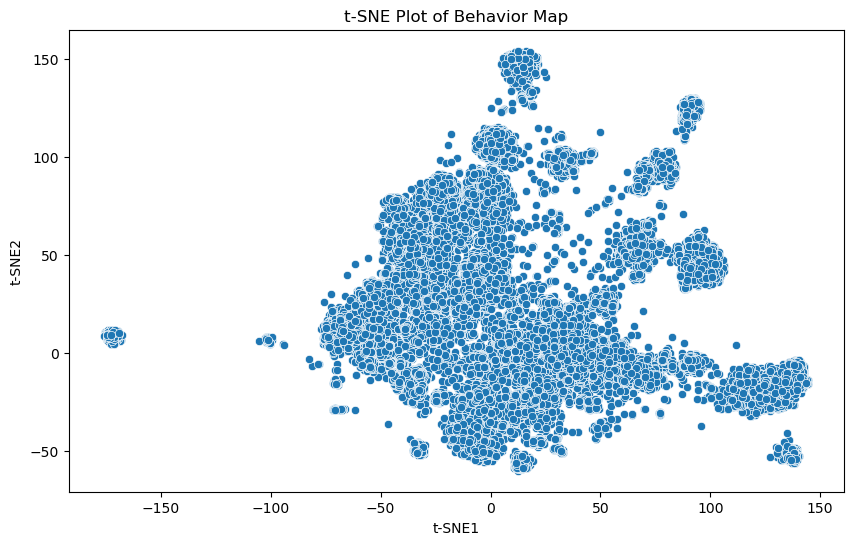

In [3]:
# Plot the t-SNE data using Seaborn

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map')

plt.show()


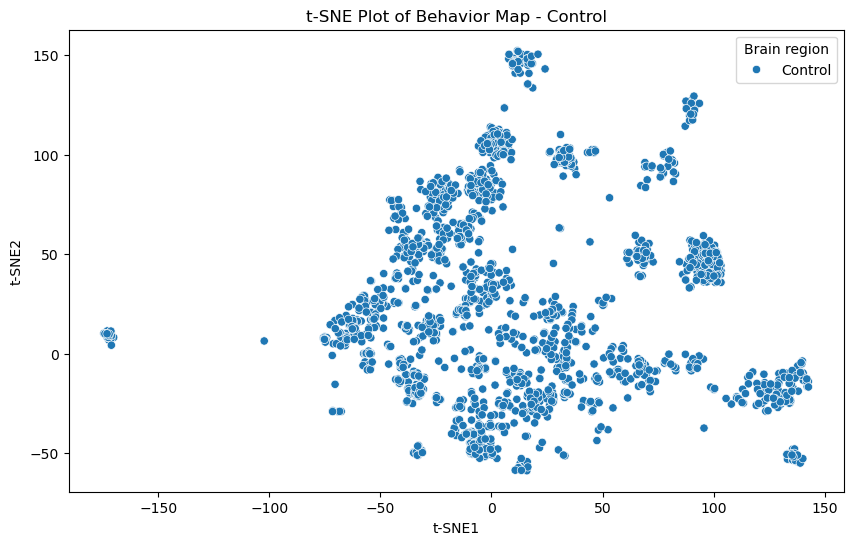

In [4]:
# Make a subset with only the "Brain region" == "Control" and plot it side by side with the "Brain region" != "Control"

control_data = TSNE_Data[TSNE_Data['Brain region'] == 'Control']

experimental_data = TSNE_Data[TSNE_Data['Brain region'] != 'Control']

# Plot the t-SNE data using Seaborn

plt.figure(figsize=(10, 6))

sns.scatterplot(data=control_data, x='t-SNE Component 1', y='t-SNE Component 2', hue="Brain region")

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map - Control')

plt.show()

In [5]:
# Extract t-SNE components
x = TSNE_Data['t-SNE Component 1']
y = TSNE_Data['t-SNE Component 2']

# Compute the KDE
kde = gaussian_kde([x, y], bw_method=0.05)

# Evaluate the KDE on a grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kde_values = kde(positions).reshape(xx.shape)



Text(0, 0.5, 't-SNE Component 2')

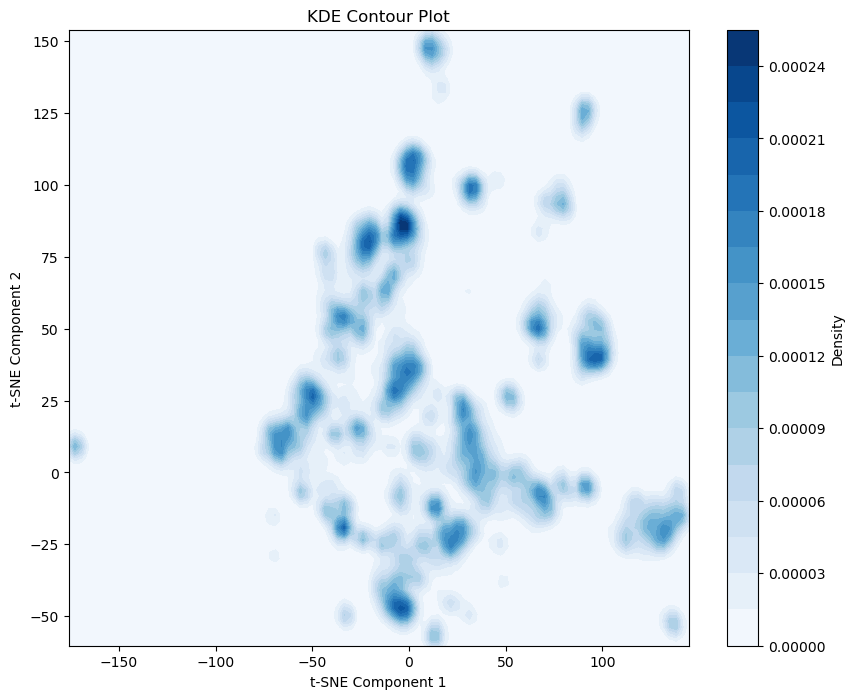

In [6]:

# Plot the KDE and extract contour levels
plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, kde_values, levels=20, cmap="Blues")
plt.colorbar(label="Density")
plt.title("KDE Contour Plot")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
#plt.show()



In [7]:

# Extract the top 5 density levels (darkest shades)
top_levels = contour.levels[-12:]  # Adjust number of levels if needed
threshold = top_levels[0]  # Use the lowest value of the top 5 levels as threshold


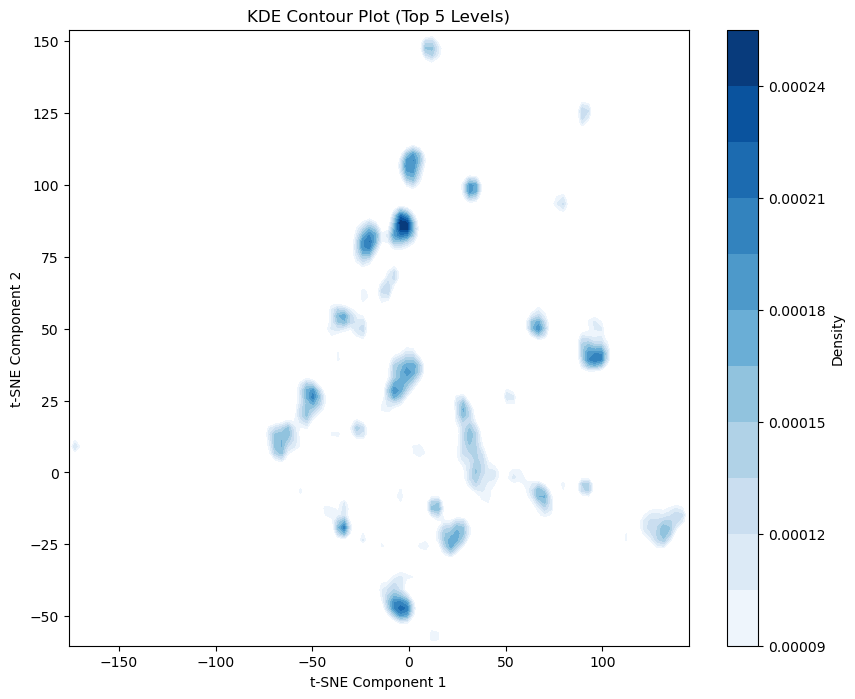

In [8]:

# Plot the area of contour levels above the threshold

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, kde_values, levels=top_levels, cmap="Blues")

plt.colorbar(label="Density")

plt.title("KDE Contour Plot (Top 5 Levels)")

plt.xlabel("t-SNE Component 1")

plt.ylabel("t-SNE Component 2")

plt.show()


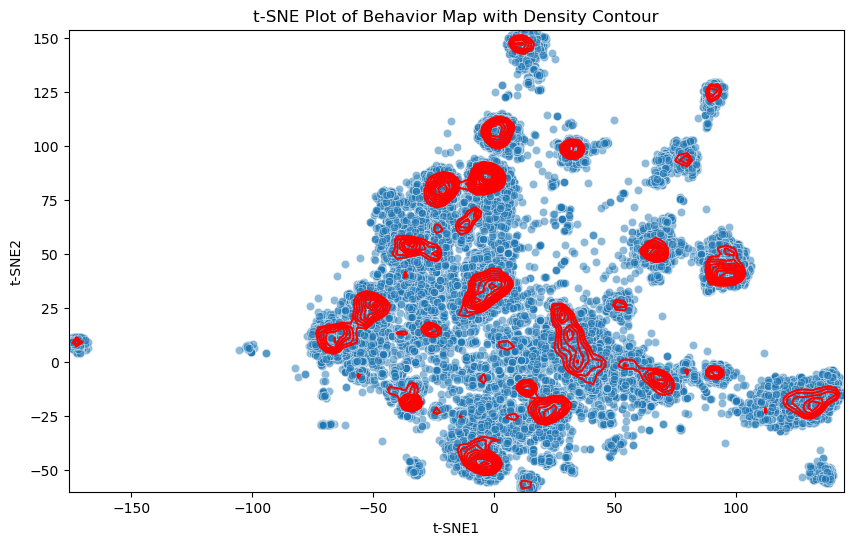

In [9]:

# Plot the TSNE data with contour around the top 5 density levels

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', alpha=0.5)

plt.contour(xx, yy, kde_values, levels=top_levels, colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map with Density Contour')

plt.show()



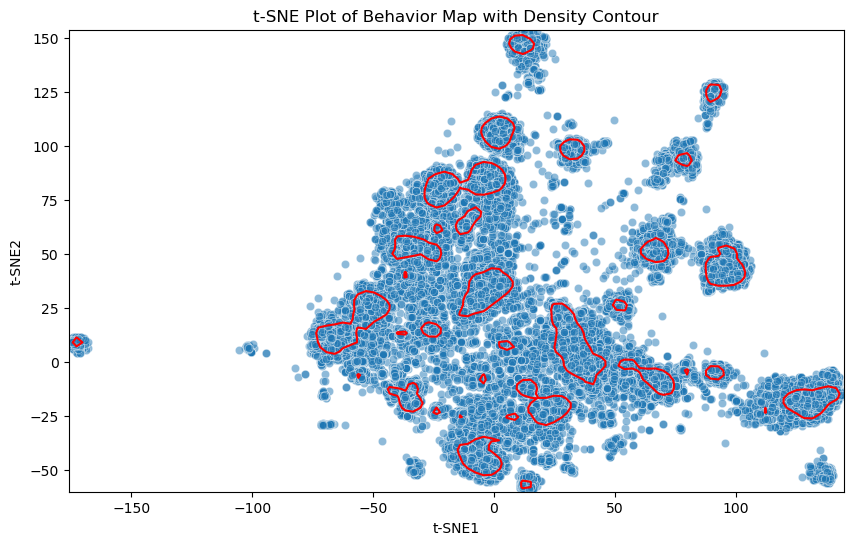

In [10]:

# Redo but get only the lowest contour level among the selected levels

plt.figure(figsize=(10, 6))

sns.scatterplot(data=TSNE_Data, x='t-SNE Component 1', y='t-SNE Component 2', alpha=0.5)

plt.contour(xx, yy, kde_values, levels=[threshold], colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('t-SNE Plot of Behavior Map with Density Contour')

plt.show()



In [11]:

# Make a list of the distinct areas of the contour plot

contour_areas = []

for i in range(len(top_levels) - 1):
    
    # Get the area of the contour between the current and next levels
    area = np.sum(kde_values * (kde_values >= top_levels[i]) * (kde_values < top_levels[i + 1]))
    
    contour_areas.append(area)
    
# Display the areas of the contour plot

contour_areas

# Find the indices of the points that are within the contour area

points_in_contour = np.where(kde_values >= threshold)

# Extract the x and y coordinates of the points within the contour area

x_in_contour = xx[points_in_contour]

y_in_contour = yy[points_in_contour]



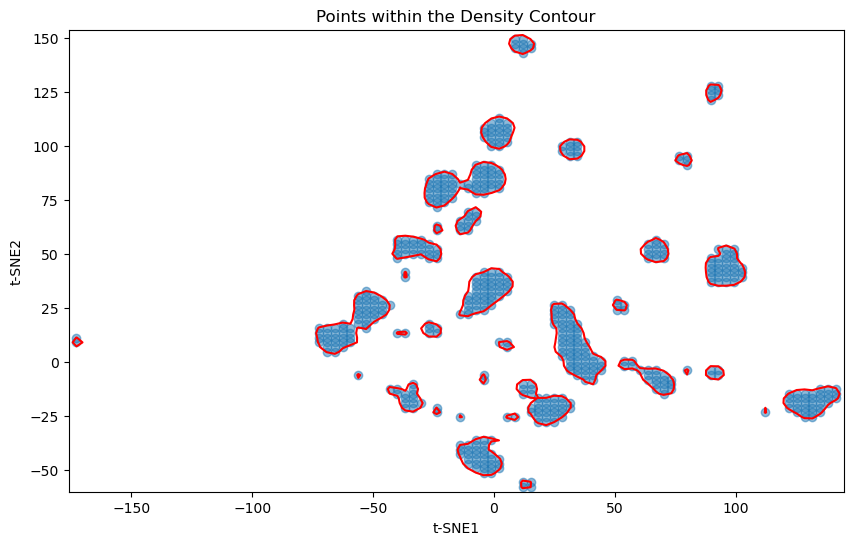

In [12]:


# Plot the points within the contour area

plt.figure(figsize=(10, 6))

plt.scatter(x_in_contour, y_in_contour, alpha=0.5)

plt.contour(xx, yy, kde_values, levels=[threshold], colors='r')

plt.xlabel('t-SNE1')

plt.ylabel('t-SNE2')

plt.title('Points within the Density Contour')

plt.show()

In [13]:
# Assuming TSNE_Data, xx, yy, kde_values, and threshold are already defined
import os
# Create a binary mask for high-density areas
high_density_mask = kde_values >= threshold

# Label connected components in the binary mask
labeled_array, num_features = label(high_density_mask)

# Create subsets for each distinct area
subsets = []
for i in range(1, num_features + 1):
    area_mask = labeled_array == i
    x_in_area = xx[area_mask]
    y_in_area = yy[area_mask]
    
    # Find points from the original dataset that fall within this area
    points_in_area = TSNE_Data[
        (TSNE_Data['t-SNE Component 1'] >= x_in_area.min()) &
        (TSNE_Data['t-SNE Component 1'] <= x_in_area.max()) &
        (TSNE_Data['t-SNE Component 2'] >= y_in_area.min()) &
        (TSNE_Data['t-SNE Component 2'] <= y_in_area.max())
    ]
    
    # If the area is not empty, save it to a subset list and a file
    if len(points_in_area) > 0:
        filename = f"/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/250107_LooseContacts_Mapped/250107_behavior_map_tsne_area_{i}.feather"
        # Check if the file already exists
        if os.path.exists(filename):
            print(f"File {filename} already exists, skipping save.")
        else:
            points_in_area.to_feather(filename)
        subsets.append((i, points_in_area))
        print(f"Saved Area {i} with {len(points_in_area)} points to {filename}")


File /mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/250107_LooseContacts_Mapped/250107_behavior_map_tsne_area_2.feather already exists, skipping save.
Saved Area 2 with 1242 points to /mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/250107_LooseContacts_Mapped/250107_behavior_map_tsne_area_2.feather
File /mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/250107_LooseContacts_Mapped/250107_behavior_map_tsne_area_4.feather already exists, skipping save.
Saved Area 4 with 1462 points to /mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/250107_LooseContacts_Mapped/250107_behavior_map_tsne_area_4.feather
File /mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/250107_LooseContacts_Mapped/250107_behavior_map_tsne_area_5.feather already exists, skipping save.
Saved Area 5 with 964 points to /mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/Cluster_data/2501

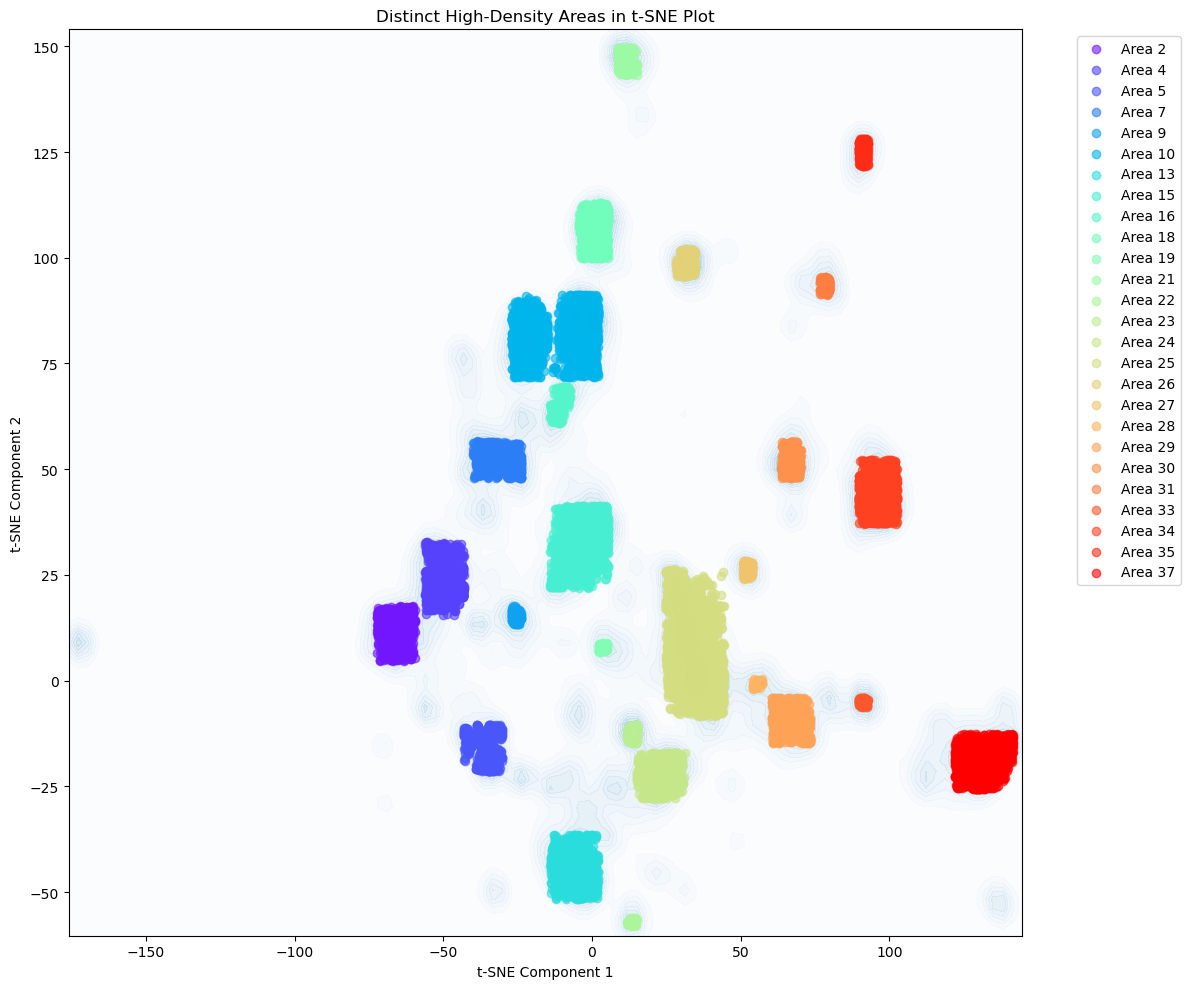

Area 2: 1242 points
Area 4: 1462 points
Area 5: 964 points
Area 7: 923 points
Area 9: 163 points
Area 10: 3499 points
Area 13: 1723 points
Area 15: 2326 points
Area 16: 422 points
Area 18: 1168 points
Area 19: 67 points
Area 21: 338 points
Area 22: 90 points
Area 23: 216 points
Area 24: 1300 points
Area 25: 3357 points
Area 26: 469 points
Area 27: 168 points
Area 28: 47 points
Area 29: 919 points
Area 30: 544 points
Area 31: 135 points
Area 33: 103 points
Area 34: 1574 points
Area 35: 206 points
Area 37: 1545 points


In [14]:

# Plot each distinct area with a different color
plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, kde_values, levels=20, cmap="Blues", alpha=0.3)

colors = plt.cm.rainbow(np.linspace(0, 1, num_features))
for i, (area_index, subset) in enumerate(subsets):
    plt.scatter(subset['t-SNE Component 1'], subset['t-SNE Component 2'], 
                color=colors[area_index - 1], label=f'Area {area_index}', alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Distinct High-Density Areas in t-SNE Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

# Print information about each subset
for area_index, subset in subsets:
    print(f"Area {area_index}: {len(subset)} points")

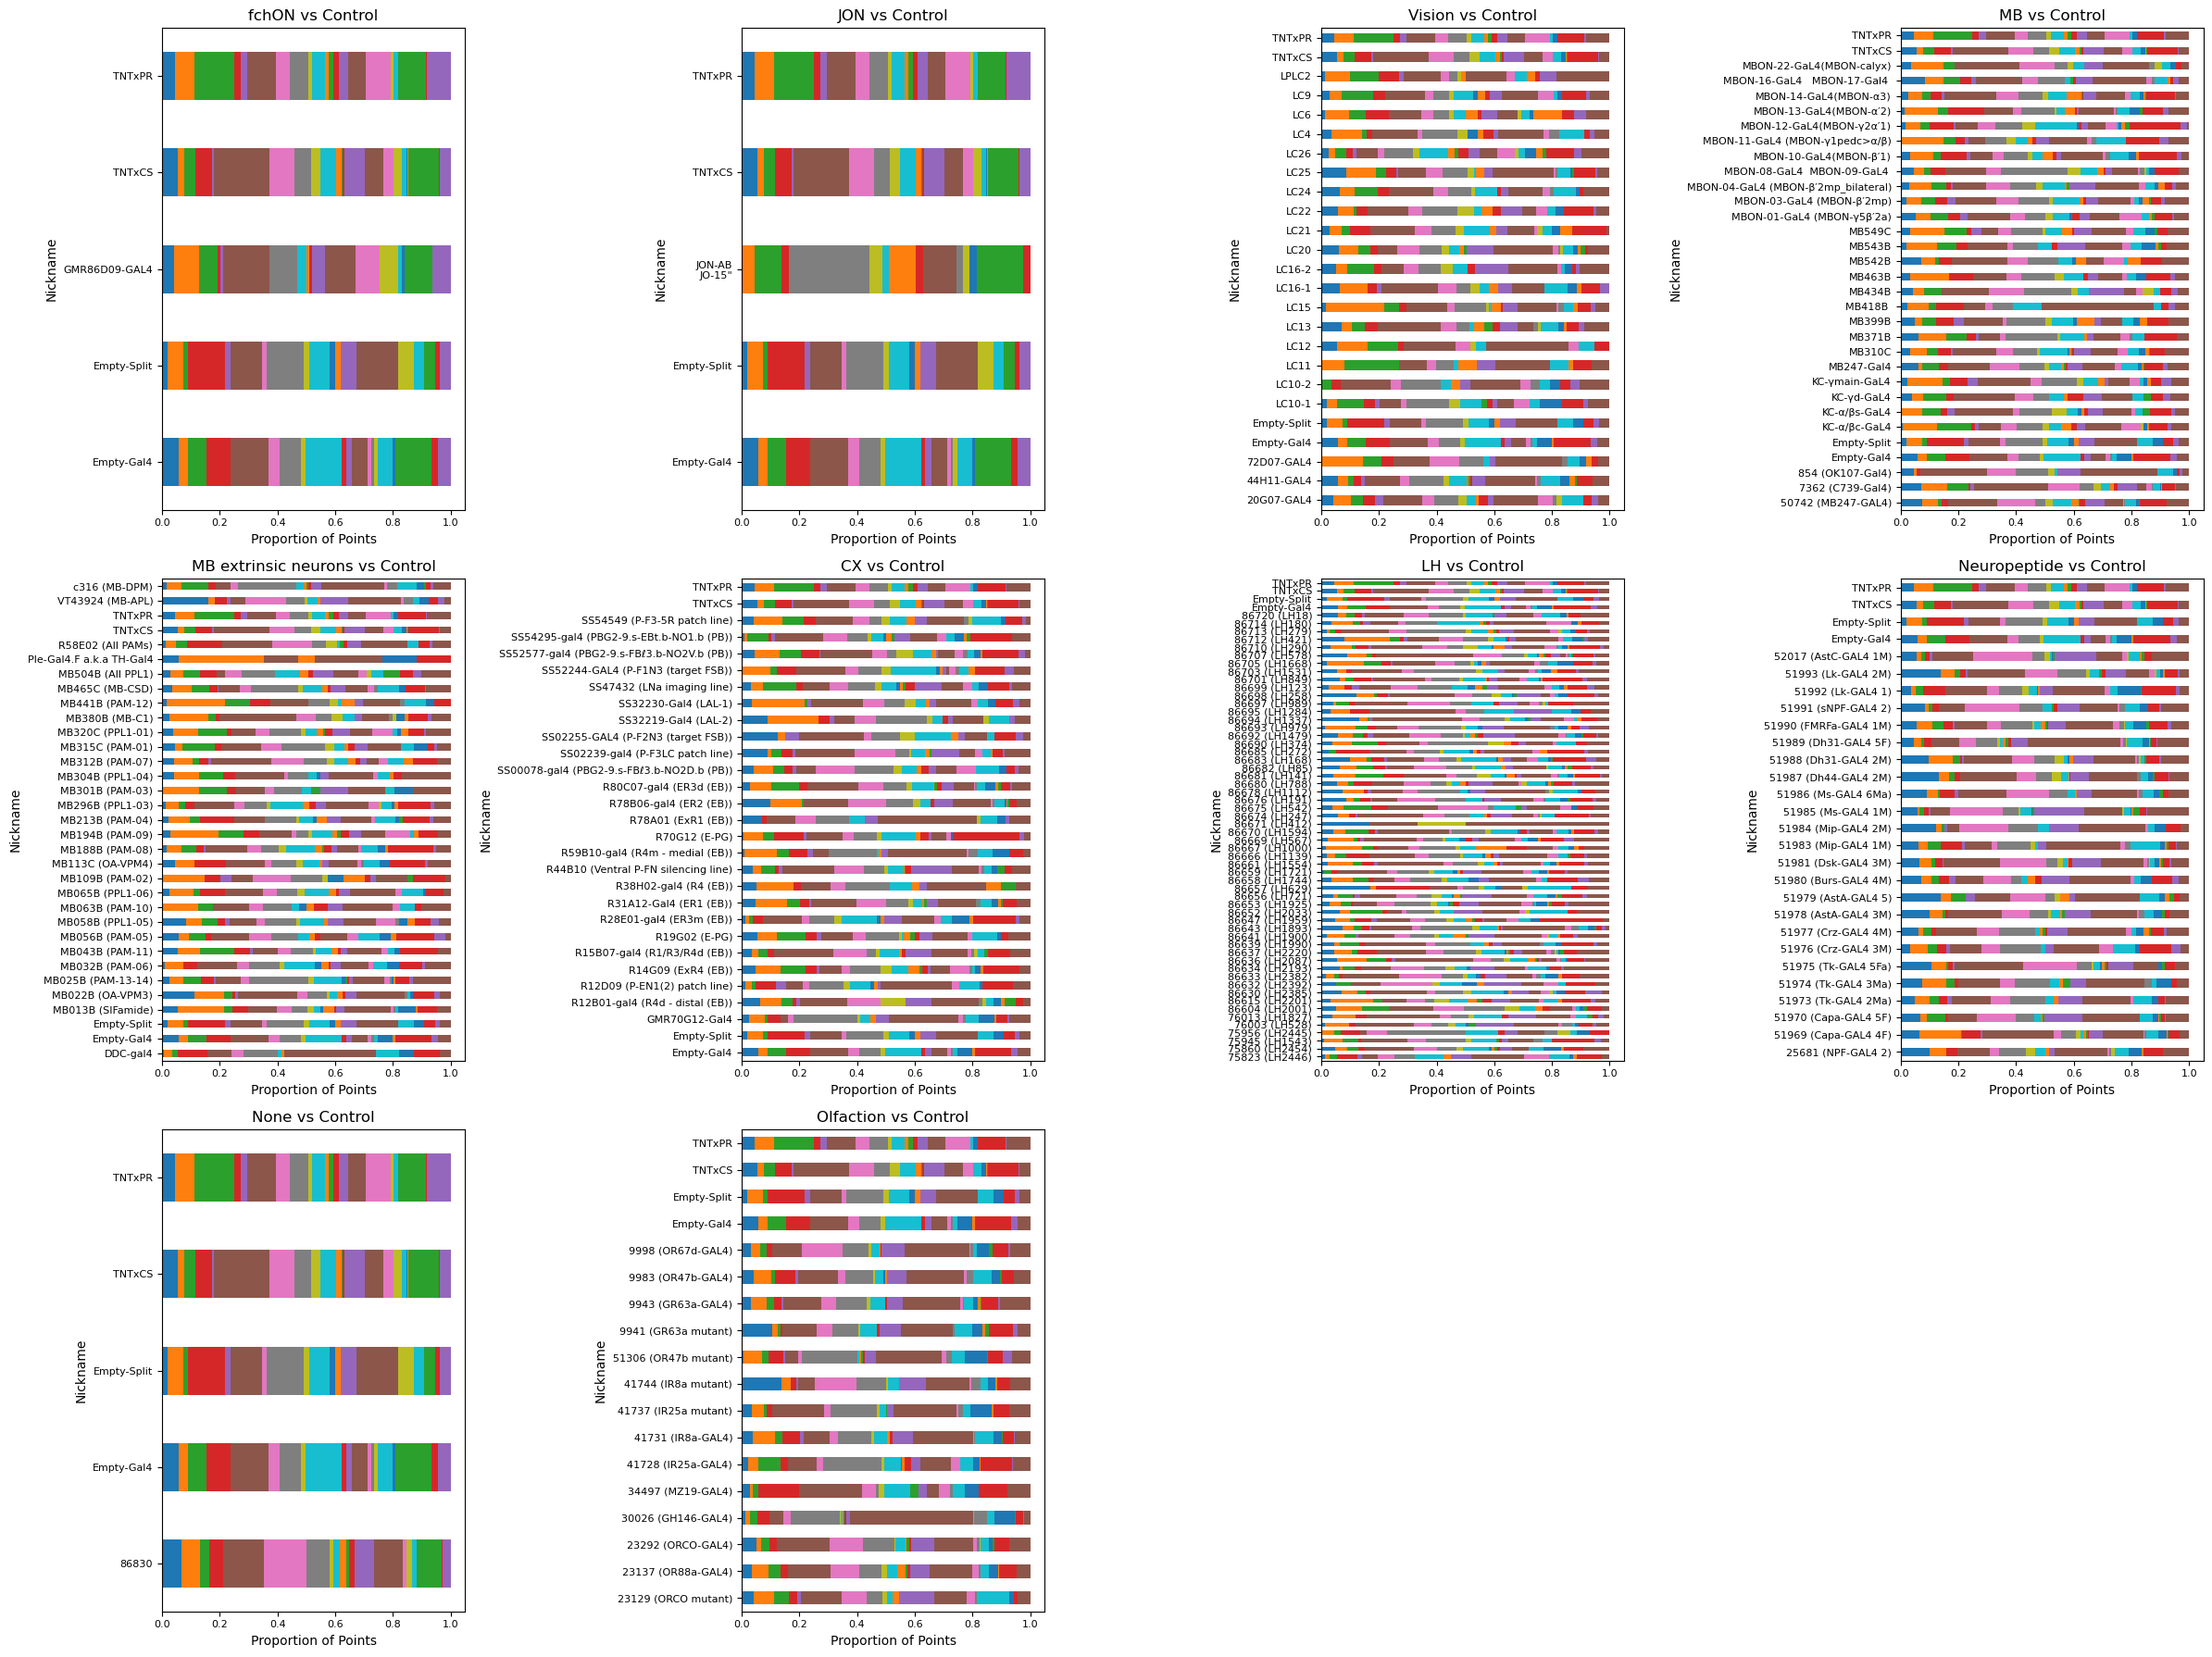

In [17]:
# Define the control region and get unique brain regions
control_region = 'Control'
brain_regions = TSNE_Data['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

# Calculate the number of rows and columns for the subplot grid
n_regions = len(brain_regions)
n_cols = 4  # You can adjust this value
n_rows = math.ceil(n_regions / n_cols)

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), squeeze=False)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

for idx, region in enumerate(brain_regions):
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = TSNE_Data[TSNE_Data['Brain region'].isin([control_region, region])]
    
    # Create subsets for each distinct area
    area_counts = {}
    for i in range(1, num_features + 1):
        area_mask = labeled_array == i
        x_in_area = xx[area_mask]
        y_in_area = yy[area_mask]

        points_in_area = subset_data[
            (subset_data['t-SNE Component 1'] >= x_in_area.min()) &
            (subset_data['t-SNE Component 1'] <= x_in_area.max()) &
            (subset_data['t-SNE Component 2'] >= y_in_area.min()) &
            (subset_data['t-SNE Component 2'] <= y_in_area.max())
        ]

        if len(points_in_area) > 0:
            area_name = f'Area {i}'
            nickname_counts = points_in_area['Nickname'].value_counts()
            area_counts[area_name] = nickname_counts

    # Combine all area counts into a single DataFrame
    combined_counts = pd.DataFrame(area_counts).fillna(0)

    # Calculate the total count for each Nickname
    total_counts = combined_counts.sum(axis=1)

    # Normalize counts to get proportions
    normalized_proportions = combined_counts.div(total_counts, axis=0)

    # Plot the normalized proportions
    ax = axes_flat[idx]
    normalized_proportions.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(f'{region} vs {control_region}')
    ax.set_xlabel('Proportion of Points')
    ax.set_ylabel('Nickname')
    ax.legend(title='High-Density Area', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.get_legend().remove()
    
    # Adjust layout for better readability
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)

# Remove any unused subplots
for j in range(idx+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Contacts/250203BehaviorProps_Grid.png", bbox_inches='tight')
plt.show()

# Print the proportions for each Nickname (optional)
#print(combined_proportions)

In [18]:
# Assuming TSNE_Data, labeled_array, xx, yy, and num_features are already defined

# Create a list to store the data for each contact
contacts_data = []

# Define the control region and get unique brain regions
control_region = 'Control'
brain_regions = TSNE_Data['Brain region'].unique()
brain_regions = [region for region in brain_regions if region != control_region]

for region in brain_regions:
    # Subset the data for the Control Brain region and the current Brain region
    subset_data = TSNE_Data[TSNE_Data['Brain region'].isin([control_region, region])]
    
    # Create subsets for each distinct area
    for i in range(1, num_features + 1):
        area_mask = labeled_array == i
        x_in_area = xx[area_mask]
        y_in_area = yy[area_mask]

        points_in_area = subset_data[
            (subset_data['t-SNE Component 1'] >= x_in_area.min()) &
            (subset_data['t-SNE Component 1'] <= x_in_area.max()) &
            (subset_data['t-SNE Component 2'] >= y_in_area.min()) &
            (subset_data['t-SNE Component 2'] <= y_in_area.max())
        ]

        if len(points_in_area) > 0:
            area_name = f'Area {i}'
            for _, row in points_in_area.iterrows():
                contact_info = row.to_dict()
                contact_info['Area'] = area_name
                contacts_data.append(contact_info)

# Create a DataFrame from the contacts data
contacts_df = pd.DataFrame(contacts_data)

contacts_df.head()

,t-SNE Component 1,t-SNE Component 2,start,contact_index,fly,flypath,experiment,Nickname,Brain region,Date,Genotype,Period,FeedingState,Orientation,Light,Crossing,Area
0,-64.011269,10.192883,582.206897,13.0,231115_TNT_Fine_1_Videos_Tracked_arena2_corridor2,/mnt/upramdya_data/MD/MultiMazeRecorder/Videos...,231115_TNT_Fine_1_Videos_Tracked,GMR86D09-GAL4,fchON,231115,TNTxG54,PM14,starved_noWater,std,on,1,Area 2
1,-68.919106,9.326910,730.344828,14.0,231115_TNT_Fine_1_Videos_Tracked_arena2_corridor6,/mnt/upramdya_data/MD/MultiMazeRecorder/Videos...,231115_TNT_Fine_1_Videos_Tracked,GMR86D09-GAL4,fchON,231115,TNTxG54,PM14,starved_noWater,std,on,1,Area 2
2,-64.404022,9.194839,416.517241,5.0,231121_TNT_Fine_2_Videos_Tracked_arena9_corridor6,/mnt/upramdya_data/MD/MultiMazeRecorder/Videos...,231121_TNT_Fine_2_Videos_Tracked,GMR86D09-GAL4,fchON,231121,TNTxG54,PM15,starved_noWater,std,on,1,Area 2
3,-63.786289,10.052521,644.517241,12.0,231121_TNT_Fine_2_Videos_Tracked_arena9_corridor6,/mnt/upramdya_data/MD/MultiMazeRecorder/Videos...,231121_TNT_Fine_2_Videos_Tracked,GMR86D09-GAL4,fchON,231121,TNTxG54,PM15,starved_noWater,std,on,1,Area 2
4,-65.566154,6.501959,194.413793,4.0,240104_TNT_Fine_1_Videos_Tracked_arena9_corridor3,/mnt/upramdya_data/MD/MultiMazeRecorder/Videos...,240104_TNT_Fine_1_Videos_Tracked,Empty-Split,Control,240104,TNTxZ2035,PM14,starved_noWater,std,on,1,Area 2


In [ ]:
contacts_df.columns

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming contacts_df is already defined and contains a 'fly' column

# Calculate the total number of contacts for each fly
total_contacts_per_fly = contacts_df.groupby('fly').size()

# Calculate the number of contacts for each fly in each Area
contacts_per_area_fly = contacts_df.groupby(['Area', 'fly']).size().unstack(fill_value=0)

# Calculate the proportion of contacts in each Area for each fly
proportions_per_area_fly = contacts_per_area_fly.div(total_contacts_per_fly, axis=1).fillna(0)

# Transpose the DataFrame to get the 'fly' values back as a column
proportions_per_area_fly = proportions_per_area_fly.T

# Reset the index to convert the DataFrame to a long format suitable for merging with metadata
proportions_long = proportions_per_area_fly.reset_index().rename(columns={'index': 'fly'})

# Ensure the 'fly' column is present in proportions_long
#print("Columns in proportions_long:", proportions_long.columns)

# Merge the proportions with the metadata
metadata = contacts_df[['fly', 'Nickname', 'Brain region']].drop_duplicates().set_index('fly')
#print("Metadata index:", metadata.index)

proportions_with_metadata = proportions_long.merge(metadata, left_on='fly', right_index=True)

# Print the first few rows of the new dataset
#print(proportions_with_metadata.head())

# Now you can use this dataset for further analysis or visualization
# For example, create a boxplot with the proportions, using the Nickname as the hue
proportions_melted = proportions_with_metadata.melt(id_vars=['fly', 'Nickname', 'Brain region'], var_name='Area', value_name='Proportion')


proportions_melted.head()


,fly,Nickname,Brain region,Area,Proportion
0,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1,"JON-AB\nJO-15""",JON,Area 10,0.000000
1,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor3,"JON-AB\nJO-15""",JON,Area 10,0.000000
2,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor4,"JON-AB\nJO-15""",JON,Area 10,0.000000
3,231115_TNT_Fine_1_Videos_Tracked_arena2_corridor2,GMR86D09-GAL4,fchON,Area 10,0.142857
4,231115_TNT_Fine_1_Videos_Tracked_arena2_corridor3,GMR86D09-GAL4,fchON,Area 10,0.250000


In [20]:
# Get all unique Nicknames associated with Brain region "Control"

proportions_melted[proportions_melted['Brain region'] == 'Control']['Nickname'].unique()

array(['Empty-Split', 'TNTxCS', 'TNTxPR', 'Empty-Gal4'], dtype=object)

In [21]:
controls = ['TNTxCS', 'TNTxPR', 'Empty-Gal4', 'Empty-Split']

In [ ]:
Area24 = proportions_melted[proportions_melted['Area'] == 'Area 24']

Area24

In [ ]:
TestPlot = HoloviewsTemplates.jitter_boxplot(data=Area24, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot',render="grouped",groupby='Brain region')

In [ ]:
TestPlot

In [ ]:
hv.save(TestPlot, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/Area1.html")

In [ ]:
importlib.reload(HoloviewsTemplates)

In [ ]:
# Create a list to store the plots
plots = []

# Loop through each area and generate the plot
for area in nickname_proportions_df.index:
    area_data = proportions_melted[proportions_melted['Area'] == area]
    
    # Check if there are controls in the subset
    if not any(control in area_data['Nickname'].unique() for control in controls):
        print(f"No controls found in {area}, skipping this area.")
        continue
    
    plot = HoloviewsTemplates.jitter_boxplot(data=area_data, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot', render="grouped", groupby='Brain region')
    plot.opts(title=f'Proportion of Points in {area}')
    plots.append(plot)

# Combine the plots into a layout
layout = hv.Layout(plots).cols(3)

# Save the layout to an HTML file
hv.save(layout, '/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/proportion_plots.html')

In [ ]:
# Create a list to store the plots
plots = []

# Loop through each area and generate the plot
for area in nickname_proportions_df.index:
    area_data = proportions_melted[proportions_melted['Area'] == area]
    
    # Check if there are controls in the subset
    has_controls = any(control in area_data['Nickname'].unique() for control in controls)
    
    if has_controls:
        plot = HoloviewsTemplates.jitter_boxplot(data=area_data, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot', render="grouped", groupby='Brain region')
        plot = plot.opts(title=f'Proportion of Points in {area}')
    else:
        plot = HoloviewsTemplates.jitter_boxplot(data=area_data, metric='Proportion', kdims='Nickname', control=None, hline=None, render="grouped", groupby='Brain region')
        plot = plot.opts(title=f'Proportion of Points in {area} (No Controls)', fontsize={'title': '12pt'})
        annotation = hv.Text(0.5, 0.5, 'No Controls', halign='center', valign='center').opts(style=dict(text_font_size='20pt', text_color='red'))
        plot = plot * annotation
    
    plot.opts(title=f'Proportion of Points in {area}')
    plots.append(plot)

# Combine the plots into a layout
layout = hv.Layout(plots).cols(3)

# Save the layout to an HTML file
hv.save(layout, '/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/proportion_plots.html')

In [ ]:
# Now let's focus on areas instead of brain regions

Area14 = proportions_melted[proportions_melted['Area'] == 'Area 14']

Area14

In [ ]:
Pooled14 = HoloviewsTemplates.jitter_boxplot(data=Area1, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot',render="pooled",colorby='Brain region')

hv.save(Pooled14, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/Area14.html")

In [ ]:
for area in proportions_melted['Area'].unique():
    AreaData = proportions_melted[proportions_melted['Area'] == area]
    PooledArea = HoloviewsTemplates.jitter_boxplot(data=AreaData, metric='Proportion', kdims='Nickname', control=controls, hline='boxplot',render="pooled",colorby='Brain region')
    hv.save(PooledArea, f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/{area}.html")


In [ ]:
importlib.reload(Processing)

In [22]:
# For each area, compute the bootstrapped confidence intervals for the proportion of points in each Nickname and compare it to the control region. If the confidence interval does not overlap with the control region, flag it as significant and print the results.

# Initialize a DataFrame to store the results
areas = proportions_melted['Area'].unique()
nicknames = proportions_melted['Nickname'].unique()
results_df = pd.DataFrame(index=nicknames, columns=areas)


#For each area, compute the bootstrapped confidence intervals for the proportion of points in each Nickname and compare it to the control region
for area in areas:
    AreaData = proportions_melted[proportions_melted['Area'] == area]
    
    # Compute the bootstrapped confidence intervals for controls
    control_data = AreaData[AreaData['Brain region'] == 'Control']
    ctrl_bs_ci = Processing.draw_bs_ci(control_data['Proportion'], np.mean)
    
    # Compute the bootstrapped confidence intervals for each Nickname
    for nickname in AreaData['Nickname'].unique():
        nickname_data = AreaData[AreaData['Nickname'] == nickname]
        nickname_bs_ci = Processing.draw_bs_ci(nickname_data['Proportion'], np.mean)
        
        # Compute the difference between the Nickname and control proportions
        diff = np.mean(nickname_data['Proportion']) - np.mean(control_data['Proportion'])
        
        # Check if the confidence intervals overlap
        if nickname_bs_ci[1] < ctrl_bs_ci[0]:
            results_df.at[nickname, area] = diff  # Significant negative difference
        elif nickname_bs_ci[0] > ctrl_bs_ci[1]:
            results_df.at[nickname, area] = diff  # Significant positive difference
        else:
            results_df.at[nickname, area] = 0  # No significant difference

# Normalize the differences
max_diff = results_df.abs().max().max()
results_df = results_df / max_diff


In [ ]:
results_df

In [ ]:
print(results_df.dtypes)

In [23]:
results_df_cleaned = results_df.apply(pd.to_numeric, errors='coerce')

results_df_cleaned

,Area 10,Area 13,Area 15,Area 16,Area 18,Area 19,Area 2,Area 21,Area 22,Area 23,...,Area 30,Area 31,Area 33,Area 34,Area 35,Area 37,Area 4,Area 5,Area 7,Area 9
"JON-AB\nJO-15""",-0.480633,-0.116757,0.000000,0.000000,0.000000,0.0,-0.116142,0.000000,-0.01424,0.000000,...,-0.082134,0.0,0.0,0.000000,0.000000,-0.119111,0.000000,0.000000,0.000000,-0.029965
GMR86D09-GAL4,0.000000,-0.116757,0.000000,-0.068964,0.000000,0.0,0.000000,0.000000,-0.01424,0.000000,...,-0.070434,0.0,0.0,0.000000,-0.043948,0.000000,0.000000,0.000000,-0.178345,0.000000
LC4,0.000000,0.000000,0.000000,0.000000,-0.166040,0.0,0.000000,0.000000,-0.01424,0.000000,...,-0.082134,0.0,0.0,-0.247311,0.000000,0.000000,0.000000,-0.158503,0.000000,-0.029965
LC6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.102562,0.000000,-0.01424,0.000000,...,-0.068554,0.0,0.0,-0.183030,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029965
LC9,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.01424,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86675 (LH542),0.000000,0.000000,0.000000,-0.068964,0.000000,0.0,0.000000,-0.032143,0.00000,-0.020208,...,0.000000,0.0,0.0,0.000000,-0.043948,0.000000,0.000000,0.000000,0.000000,-0.029965
86674 (LH247),0.000000,0.000000,0.000000,-0.068964,0.000000,0.0,0.000000,-0.028598,-0.01424,0.000000,...,-0.082134,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.183854,-0.157135,0.000000
86671 (LH412),0.000000,-0.116757,-0.225902,0.000000,-0.166040,0.0,0.000000,-0.032143,-0.01424,-0.020208,...,-0.082134,0.0,0.0,-0.272661,-0.043948,0.000000,-0.171419,-0.183854,-0.190045,-0.029965
7362 (C739-Gal4),0.000000,0.194108,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.01424,0.000000,...,-0.076871,0.0,0.0,-0.168406,0.000000,0.000000,0.000000,0.000000,-0.174682,0.000000


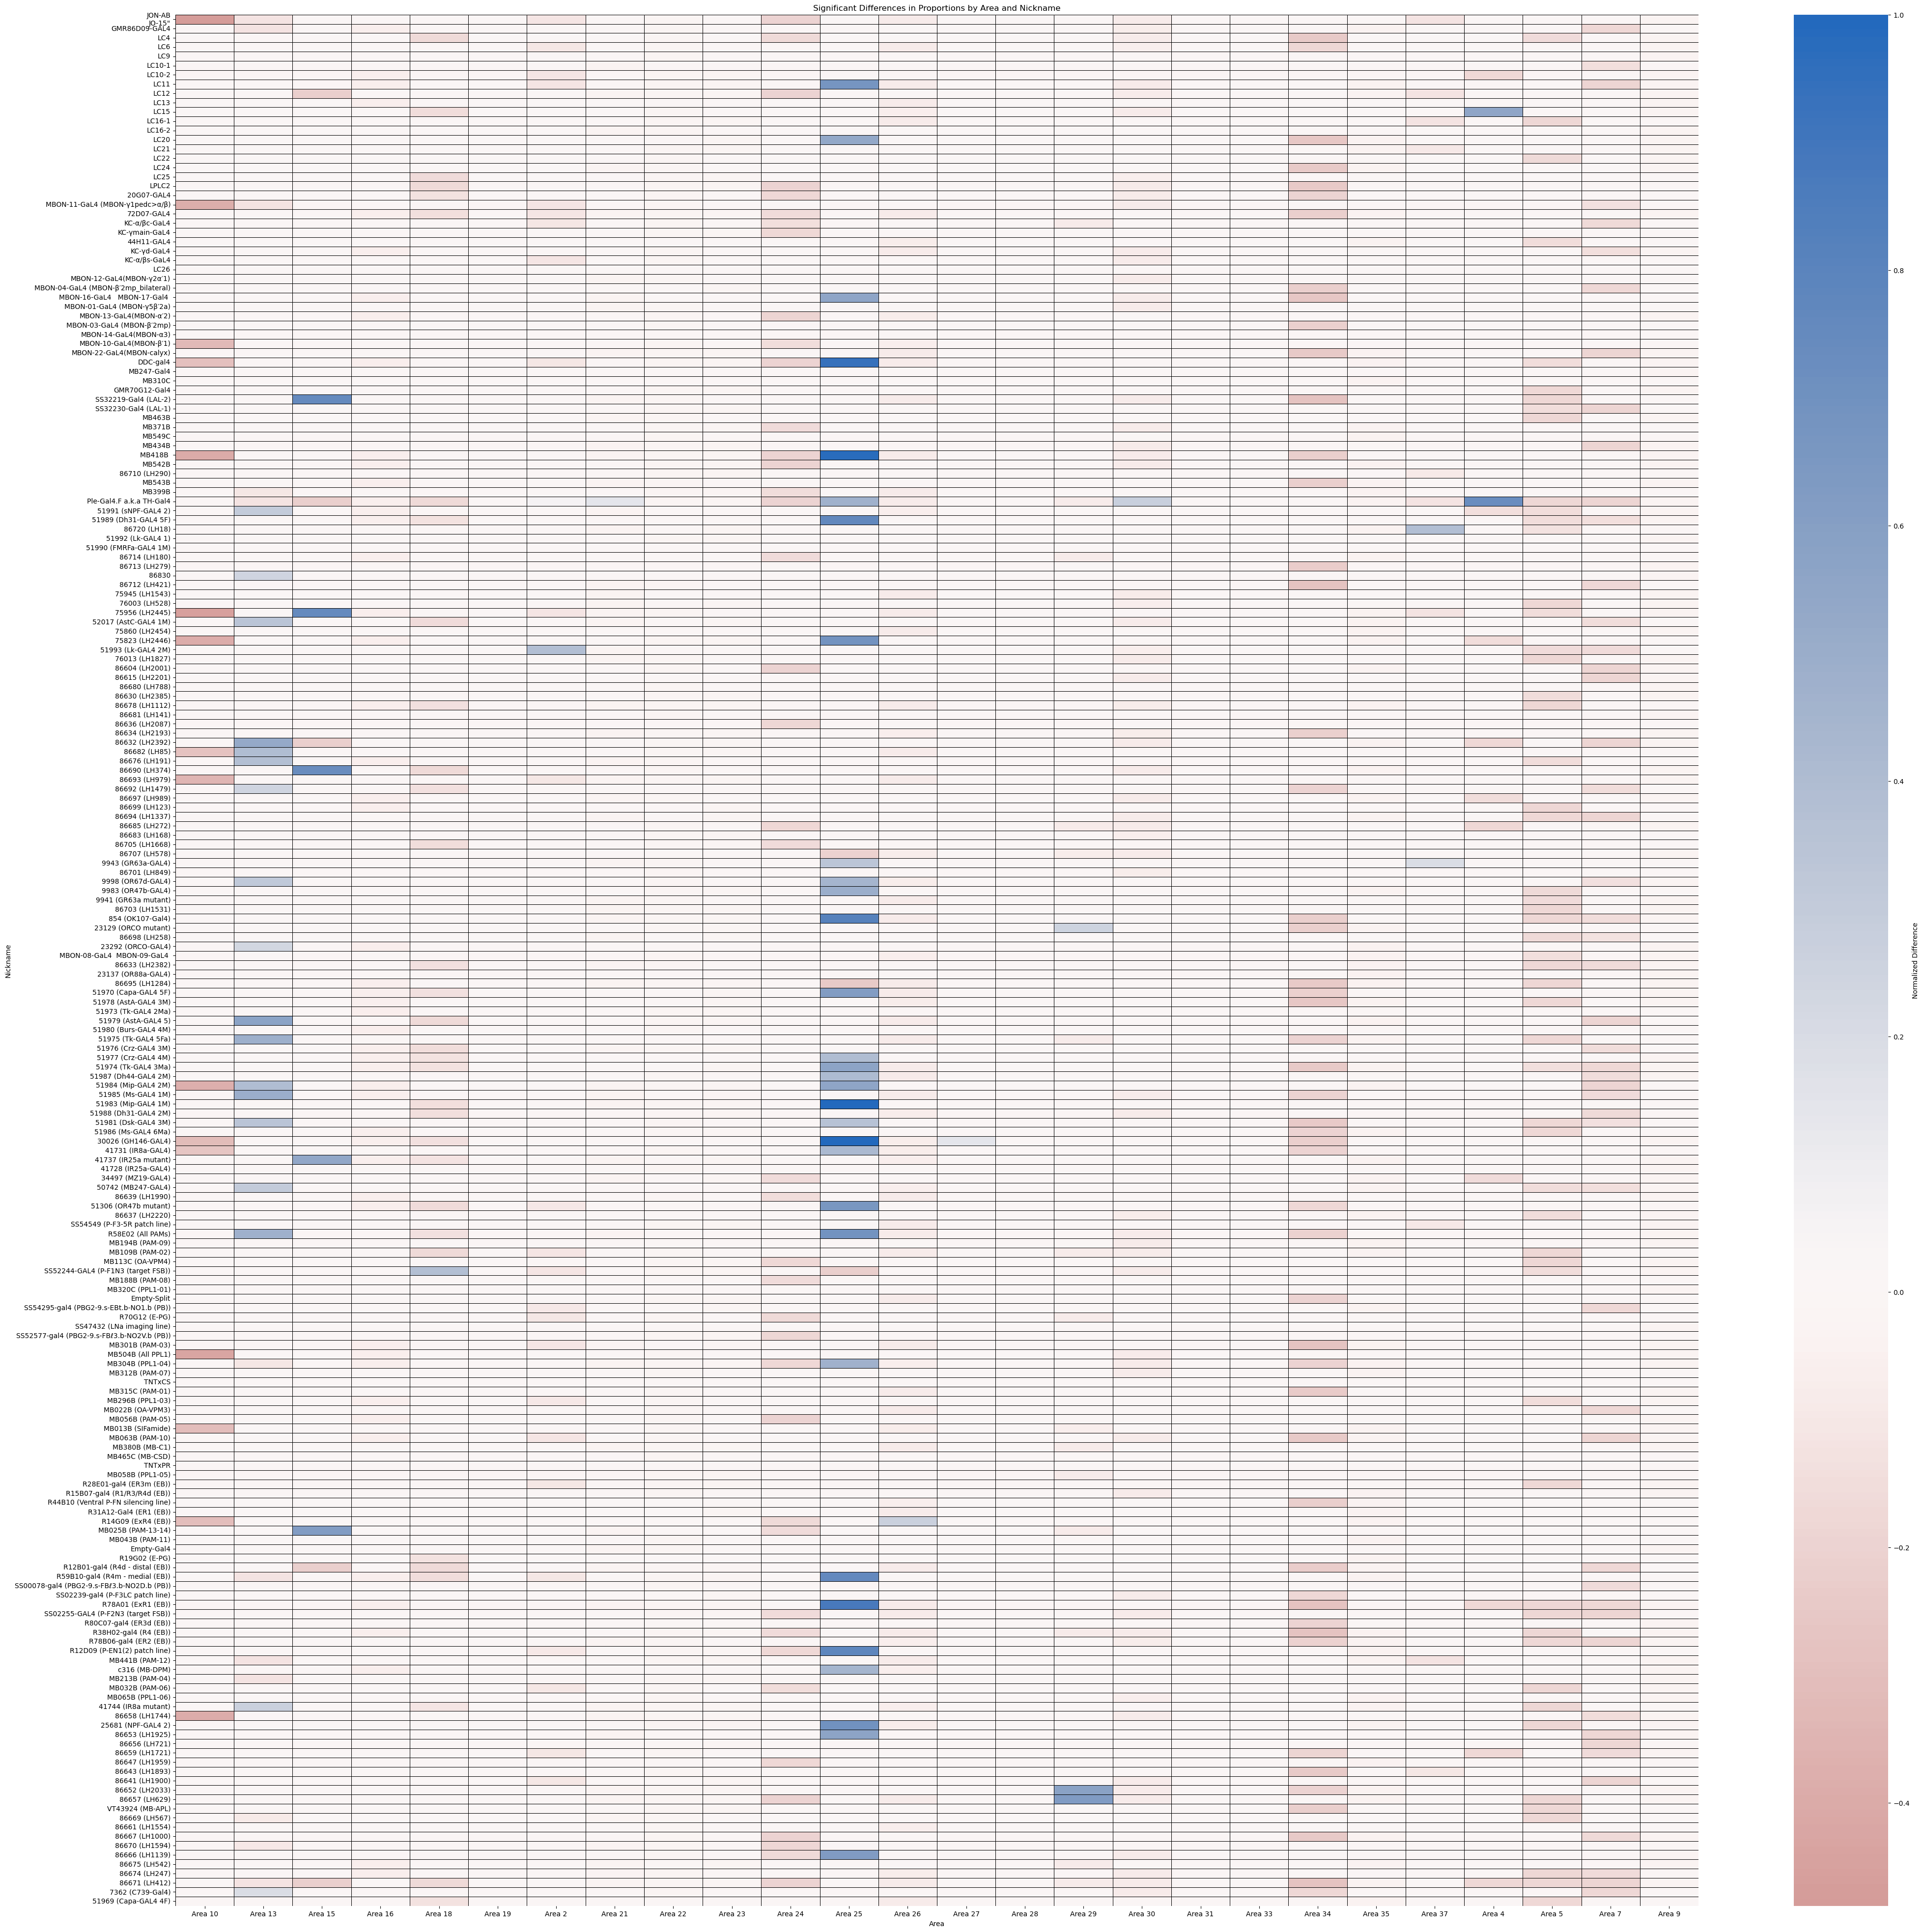

In [26]:

# Create a heatmap to visualize the results
plt.figure(figsize=(50, 50))
sns.heatmap(results_df_cleaned, annot=False, cmap='vlag_r', center=0, linewidths=.5, linecolor='black', cbar_kws={'label': 'Normalized Difference'})
plt.title('Significant Differences in Proportions by Area and Nickname')
plt.xlabel('Area')
plt.ylabel('Nickname')

plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/TNT_Fine_TSNE/250203_AreasHeatmap.png")
plt.show()
        